# Result Analysis and Visualization

## Introduction
In this notebook, we analyze the results from our ablation study and visualize the performance trade-offs between different sparsification strategies. We compare four scenarios to understand the impact of edge removal versus edge weighting on GNN performance.

**Objectives:**
1. Run comprehensive experiments across multiple sparsification ratios and metrics.
2. Decompose performance contributions from sparsification and weighting.
3. Visualize accuracy trends, effect breakdowns, and comparative analyses.
4. Draw conclusions about optimal sparsification strategies for GNNs.

In [10]:
# Consolidated imports
import sys
import os
import gc
import warnings
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import yaml
import psutil
from tqdm import tqdm
from joblib import Parallel, delayed

# Robust import: prefer editable install, fallback to path manipulation
try:
    from src import (
        AblationStudy,
        DatasetLoader,
        GraphSparsifier,
        compute_effects,
        compute_graph_stats,
        retention_to_numeric,
        run_ablation_config,
        set_global_seed,
    )
except ImportError:
    sys.path.insert(0, str(Path.cwd().parent.parent))
    from src import (
        AblationStudy,
        DatasetLoader,
        GraphSparsifier,
        compute_effects,
        compute_graph_stats,
        retention_to_numeric,
        run_ablation_config,
        set_global_seed,
    )
    print("⚠️ Using sys.path fallback. Consider running `pip install -e .` from project root.")

# Matplotlib styling
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 11

# Shared constants
METRIC_KEYS = ["jaccard", "adamic_adar", "random"]
METRIC_LABELS = ["Jaccard", "Adamic Adar", "Random"]
METRIC_COLOR = {
    "Jaccard": "#3498db",
    "Adamic Adar": "#e74c3c",
    "Random": "#f1c40f",
}

SCENARIO_COLORS = {
    "A: Full + Binary": "#2ecc71",
    "B: Sparse + Binary": "#3498db",
    "C: Full + Weighted": "#e74c3c",
    "D: Sparse + Weighted": "#9b59b6",
}

markers = {
    "Jaccard": "o",
    "Adamic Adar": "s",
    "Approx ER": "D",
    "Random": "x",
}

In [11]:
# Reusable Plotting Functions

def plot_heatmap_for_dataset_metric(df, dataset, metric, ax=None, figsize=(6, 4)):
    """Generate a single heatmap for a dataset-metric combination."""
    metric_df = df[(df["Dataset"] == dataset) & (df["Metric"] == metric)]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        standalone = True
    else:
        standalone = False
    
    if metric_df.empty:
        ax.set_title(f"{dataset} - {metric} (no data)")
        ax.axis("off")
        return ax
    
    pivot = metric_df.pivot(index="Retention", columns="Scenario", values="Accuracy").sort_index(ascending=False)
    sns.heatmap(pivot, annot=True, fmt=".1%", cmap="RdYlGn", 
                center=float(pivot.values.mean()), ax=ax, 
                cbar_kws={"label": "Test Accuracy"})
    ax.set_title(f"{dataset} - {metric}")
    ax.set_xlabel("")
    ax.set_ylabel("Retention Ratio")
    
    if standalone:
        plt.tight_layout()
    
    return ax


def plot_scenarios_for_dataset_metric(df, dataset, metric, ax=None, figsize=(6, 4)):
    """Generate scenario comparison plot for a dataset-metric combination."""
    metric_df = df[(df["Dataset"] == dataset) & (df["Metric"] == metric)]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        standalone = True
    else:
        standalone = False
    
    for scenario, color in SCENARIO_COLORS.items():
        scenario_data = metric_df[metric_df["Scenario"] == scenario].sort_values("Retention")
        ax.plot(scenario_data["Retention"], scenario_data["Accuracy"] * 100, 
                marker="o", linewidth=2, markersize=6 if standalone else 7, 
                color=color, label=scenario)
    
    ax.set_xlabel("Retention Ratio")
    ax.set_ylabel("Test Accuracy (%)")
    ax.set_title(f"{dataset} - {metric}")
    ax.legend(loc="lower left", fontsize=8 if standalone else 9)
    ax.set_xlim(0.25, 1.0)
    ax.invert_xaxis()
    ax.set_ylim(0, 100)
    
    if standalone:
        plt.tight_layout()
    
    return ax


def plot_effect_decomposition_for_dataset_metric(effect_df, dataset, metric, ax=None):
    """Generate effect decomposition plot for a dataset-metric combination."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
        standalone = True
    else:
        standalone = False
    
    effects_to_plot = ["Structure Effect (B-A)", "Weighting Effect (C-A)", "Combined Effect (D-A)"]
    colors = ["#3498db", "#e74c3c", "#9b59b6"]
    
    metric_effect_df = effect_df[(effect_df["Dataset"] == dataset) & 
                                  (effect_df["Metric"] == metric) & 
                                  (effect_df["Effect"].isin(effects_to_plot))]
    
    for i, effect in enumerate(effects_to_plot):
        effect_data = metric_effect_df[metric_effect_df["Effect"] == effect]
        ax.plot(effect_data["Retention"], effect_data["Value"] * 100,
                marker="o", linewidth=2, markersize=7, color=colors[i], label=effect)
    
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.set_xlabel("Retention Ratio")
    ax.set_ylabel("Effect (pp)")
    ax.set_title(f"{dataset} - {metric}")
    ax.legend(fontsize=9)
    ax.set_xlim(0.25, 0.95)
    ax.invert_xaxis()
    
    if standalone:
        plt.tight_layout()
    
    return ax


def save_figure(fig, output_path, dpi=200):
    """Save figure with consistent settings."""
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, dpi=dpi, bbox_inches='tight')
    

def generate_and_save_plots(df, datasets, metrics, plot_func, filename_template, 
                            combined_title, results_root=None, **kwargs):
    """
    Generic function to generate multi-panel plots and save both combined and individual figures.
    
    Args:
        df: DataFrame with results
        datasets: List of dataset names
        metrics: List of metric names
        plot_func: Function(df, dataset, metric, ax) to generate individual plot
        filename_template: Template for individual file names (e.g., "heatmap_{dataset}_{metric}.png")
        combined_title: Title for combined figure
        results_root: Root directory for results (uses Path("../results") if None)
        **kwargs: Additional arguments passed to plot_func
    """
    if results_root is None:
        results_root = Path("../results")
    
    num_ds = len(datasets)
    num_metrics = len(metrics)
    
    fig, axes = plt.subplots(num_ds, num_metrics, 
                            figsize=(5 * num_metrics, 4 * num_ds))
    axes = np.atleast_2d(axes)
    
    for row_idx, dataset in enumerate(datasets):
        ds_dir = results_root / dataset / "figures"
        ds_dir.mkdir(parents=True, exist_ok=True)
        
        for col_idx, metric in enumerate(metrics):
            ax = axes[row_idx, col_idx]
            
            # Plot on combined figure
            plot_func(df, dataset, metric, ax=ax, **kwargs)
            
            # Create and save individual figure
            fig_single, ax_single = plt.subplots(figsize=(6, 4))
            plot_func(df, dataset, metric, ax=ax_single, **kwargs)
            fig_single.tight_layout()
            
            filename = filename_template.format(
                dataset=dataset, 
                metric=metric.replace(' ', '_').lower()
            )
            save_figure(fig_single, ds_dir / filename)
            plt.close(fig_single)
    
    plt.suptitle(combined_title, fontsize=14, y=1.02)
    plt.tight_layout()
    
    return fig

In [12]:
# Configuration and Path Management
PROJECT_ROOT = Path.cwd().parent.parent
CONFIG_PATH = PROJECT_ROOT / "configs" / "config.yaml"
DATA_ROOT = PROJECT_ROOT / "data"
RESULTS_ROOT = Path("../results")

def load_config(config_path=CONFIG_PATH):
    """Load experiment configuration from YAML file."""
    if config_path.exists():
        with open(config_path) as f:
            config = yaml.safe_load(f)
        print(f"✓ Loaded config from {config_path}")
        return config
    else:
        print(f"⚠️ Config not found at {config_path}, using defaults")
        return {}

def get_config_value(config, *keys, default=None):
    """Safely extract nested config values with fallback."""
    value = config
    for key in keys:
        if isinstance(value, dict):
            value = value.get(key, {})
        else:
            return default
    return value if value != {} else default

In [13]:
set_global_seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

# Configure CPU parallelism and thread usage
N_CORES = os.cpu_count() or 1
DEFAULT_N_JOBS = max(1, N_CORES - 1)
N_JOBS = int(os.environ.get("N_JOBS", DEFAULT_N_JOBS))
WORKER_THREADS = int(os.environ.get("WORKER_THREADS", "1"))

# Limit per-process BLAS/numexpr threads to avoid oversubscription
os.environ["OMP_NUM_THREADS"] = str(WORKER_THREADS)
os.environ["MKL_NUM_THREADS"] = str(WORKER_THREADS)
os.environ["NUMEXPR_NUM_THREADS"] = str(WORKER_THREADS)

# Parent process threads
torch.set_num_threads(WORKER_THREADS)

print(f"Using device: {DEVICE}")
print(f"CPU cores available: {N_CORES}")
print(f"Parallel jobs (N_JOBS): {N_JOBS}")
print(f"Worker threads per job: {WORKER_THREADS}")

Using device: mps
CPU cores available: 10
Parallel jobs (N_JOBS): 9
Worker threads per job: 1


## 1. Run Comprehensive Experiments

In [14]:
# Quick validation: ensure all target datasets load successfully
loader = DatasetLoader(root=str(DATA_ROOT))
datasets_to_check = ["cora", "pubmed", "flickr"]

check_rows = []
for ds in datasets_to_check:
    try:
        d, nf, nc = loader.get_dataset(ds, DEVICE)
        check_rows.append({
            "Dataset": ds.title(),
            "Nodes": d.num_nodes,
            "Edges": int(d.edge_index.shape[1]),
            "Features": nf,
            "Classes": nc,
            "Status": "OK",
        })
    except Exception as e:
        check_rows.append({
            "Dataset": ds.title(),
            "Nodes": None,
            "Edges": None,
            "Features": None,
            "Classes": None,
            "Status": f"ERROR: {type(e).__name__}: {e}",
        })

check_df = pd.DataFrame(check_rows)
print("\nDataset availability check:")
print(check_df.to_string(index=False))


Dataset availability check:
Dataset  Nodes  Edges  Features  Classes Status
   Cora   2708  10556      1433        7     OK
 Pubmed  19717  88648       500        3     OK
 Flickr  89250 899756       500        7     OK


In [15]:
# Load experiment configuration
warnings.filterwarnings("ignore")
logging.getLogger("torch").setLevel(logging.ERROR)

config = load_config(CONFIG_PATH)

# Extract experiment parameters with fallbacks
datasets = get_config_value(config, "experiment", "datasets", default=["Cora", "PubMed", "Flickr"])
metrics = get_config_value(config, "experiment", "metrics", default=["jaccard", "adamic_adar", "random", "approx_er"])
retentions = get_config_value(config, "experiment", "retentions", default=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
model_name = get_config_value(config, "experiment", "model", default="gcn")
epochs = get_config_value(config, "training", "epochs", default=200)
patience = get_config_value(config, "training", "patience", default=20)
hidden = get_config_value(config, "experiment", "hidden_channels", default=64)
seed = get_config_value(config, "experiment", "seed", default=42)

print(f"Experiment Configuration:")
print(f"  Datasets: {datasets}")
print(f"  Metrics: {metrics}")
print(f"  Retentions: {len(retentions)} levels ({min(retentions)}-{max(retentions)})")
print(f"  Model: {model_name}, Hidden: {hidden}, Epochs: {epochs}, Patience: {patience}, Seed: {seed}")

✓ Loaded config from /Users/ilias/Documents/GitHub/gnn-sparsification-research/configs/config.yaml
Experiment Configuration:
  Datasets: ['Cora', 'PubMed', 'Flickr']
  Metrics: ['jaccard', 'adamic_adar', 'random', 'approx_er']
  Retentions: 10 levels (0.1-1.0)
  Model: gcn, Hidden: 64, Epochs: 200, Patience: 20, Seed: 42


In [16]:
# Define worker function for parallel ablation experiments
def run_single_config(dataset_name, metric, retention, data_root, model_name, 
                      hidden, epochs, patience, seed):
    """
    Run a single ablation configuration (designed for parallel execution).
    
    Args:
        dataset_name: Name of dataset
        metric: Sparsification metric
        retention: Edge retention ratio
        data_root: Path to data directory
        model_name, hidden, epochs, patience, seed: Training hyperparameters
    
    Returns:
        DataFrame with ablation results or None if skipped
    """
    # Skip Flickr for approx_er (too expensive)
    if dataset_name.lower() == "flickr" and metric in {"approx_er", "approx_effective_resistance", "approx-er"}:
        return None
    
    # Each worker loads its own data to avoid sharing issues
    loader = DatasetLoader(root=data_root)
    data, num_features, num_classes = loader.get_dataset(dataset_name, device="cpu")
    
    study = AblationStudy(data, num_features, num_classes, device="cpu")
    study.verbose = False
    
    df = study.run_full_study(
        model_name=model_name,
        metric=metric,
        retention_ratio=retention,
        hidden_channels=hidden,
        epochs=epochs,
        patience=patience,
        seed=seed,
    )
    
    df["Dataset"] = dataset_name
    df["Metric"] = metric
    df["Retention"] = retention
    return df

In [17]:
# Execute parallel ablation experiments
all_configs = [(d, m, r) for d in datasets for m in metrics for r in retentions]
print(f"Running {len(all_configs)} experiment configurations in parallel (N_JOBS={N_JOBS})...")

results = Parallel(n_jobs=N_JOBS, verbose=0, prefer="processes")(
    delayed(run_single_config)(d, m, r, str(DATA_ROOT), model_name, hidden, epochs, patience, seed)
    for d, m, r in tqdm(all_configs, desc="Experiments")
)

# Filter None results and combine
results = [r for r in results if r is not None]
combined = pd.concat(results, ignore_index=True) if results else pd.DataFrame()

print(f"\n✓ Completed {len(results)}/{len(all_configs)} configurations")
print(f"✓ Combined results shape: {combined.shape}")

# Save results
results_file = RESULTS_ROOT / "ablation_results_all_datasets.csv"
results_file.parent.mkdir(parents=True, exist_ok=True)
combined.to_csv(results_file, index=False)
print(f"✓ Results saved to {results_file}")

gc.collect()
print("✓ Memory cleared")

Running 120 experiment configurations in parallel (N_JOBS=9)...


Experiments: 100%|██████████| 120/120 [54:26<00:00, 27.22s/it]



✓ Completed 110/120 configurations
✓ Combined results shape: (440, 11)
✓ Results saved to ../results/ablation_results_all_datasets.csv
✓ Memory cleared


## 2. Load Results for Visualization

In [18]:
# Load saved results for visualization
results_csv = RESULTS_ROOT / "ablation_results_all_datasets.csv"

if results_csv.exists():
    print(f"📂 Loading results from {results_csv}...")
    df = pd.read_csv(results_csv)
    print(f"✓ Loaded {len(df)} rows")
else:
    print("⚠️ CSV not found - using combined results from memory")
    df = combined.copy()

# Normalize column values for consistency
df["Metric"] = df["Metric"].str.replace("_", " ").str.title()
df["Metric"] = df["Metric"].str.replace("Approx Er", "Approx ER", regex=False)
df["Dataset"] = df["Dataset"].str.title()

mem = psutil.virtual_memory()
print(f"\n📊 Memory: {mem.available / 1e9:.1f}GB available ({mem.percent:.0f}% used)")
print(f"📊 Results shape: {df.shape}")
print(f"📊 Datasets: {sorted(df['Dataset'].unique())}")
print(f"📊 Metrics: {sorted(df['Metric'].unique())}\n")
print(df.head(8))

📂 Loading results from ../results/ablation_results_all_datasets.csv...
✓ Loaded 440 rows

📊 Memory: 11.3GB available (56% used)
📊 Results shape: (440, 11)
📊 Datasets: ['Cora', 'Flickr', 'Pubmed']
📊 Metrics: ['Adamic Adar', 'Approx ER', 'Jaccard', 'Random']

               Scenario  Accuracy  Epochs  BestValAcc  Edges  PreprocessSec  \
0      A: Full + Binary     0.789      29       0.788  10556       0.015871   
1    B: Sparse + Binary     0.607      31       0.606   1055       0.015872   
2    C: Full + Weighted     0.723      28       0.758  10556       0.015871   
3  D: Sparse + Weighted     0.601      31       0.608   1055       0.015871   
4      A: Full + Binary     0.789      29       0.788  10556       0.015002   
5    B: Sparse + Binary     0.618      36       0.664   2111       0.015002   
6    C: Full + Weighted     0.723      28       0.758  10556       0.015002   
7  D: Sparse + Weighted     0.609      30       0.636   2111       0.015002   

   TrainSec  PeakMemMB Dataset

## 3. Heatmap: Test Accuracy by Retention and Scenario

✓ Saved combined heatmaps to ../results/heatmaps_all_datasets.png
✓ Saved individual heatmaps to per-dataset folders


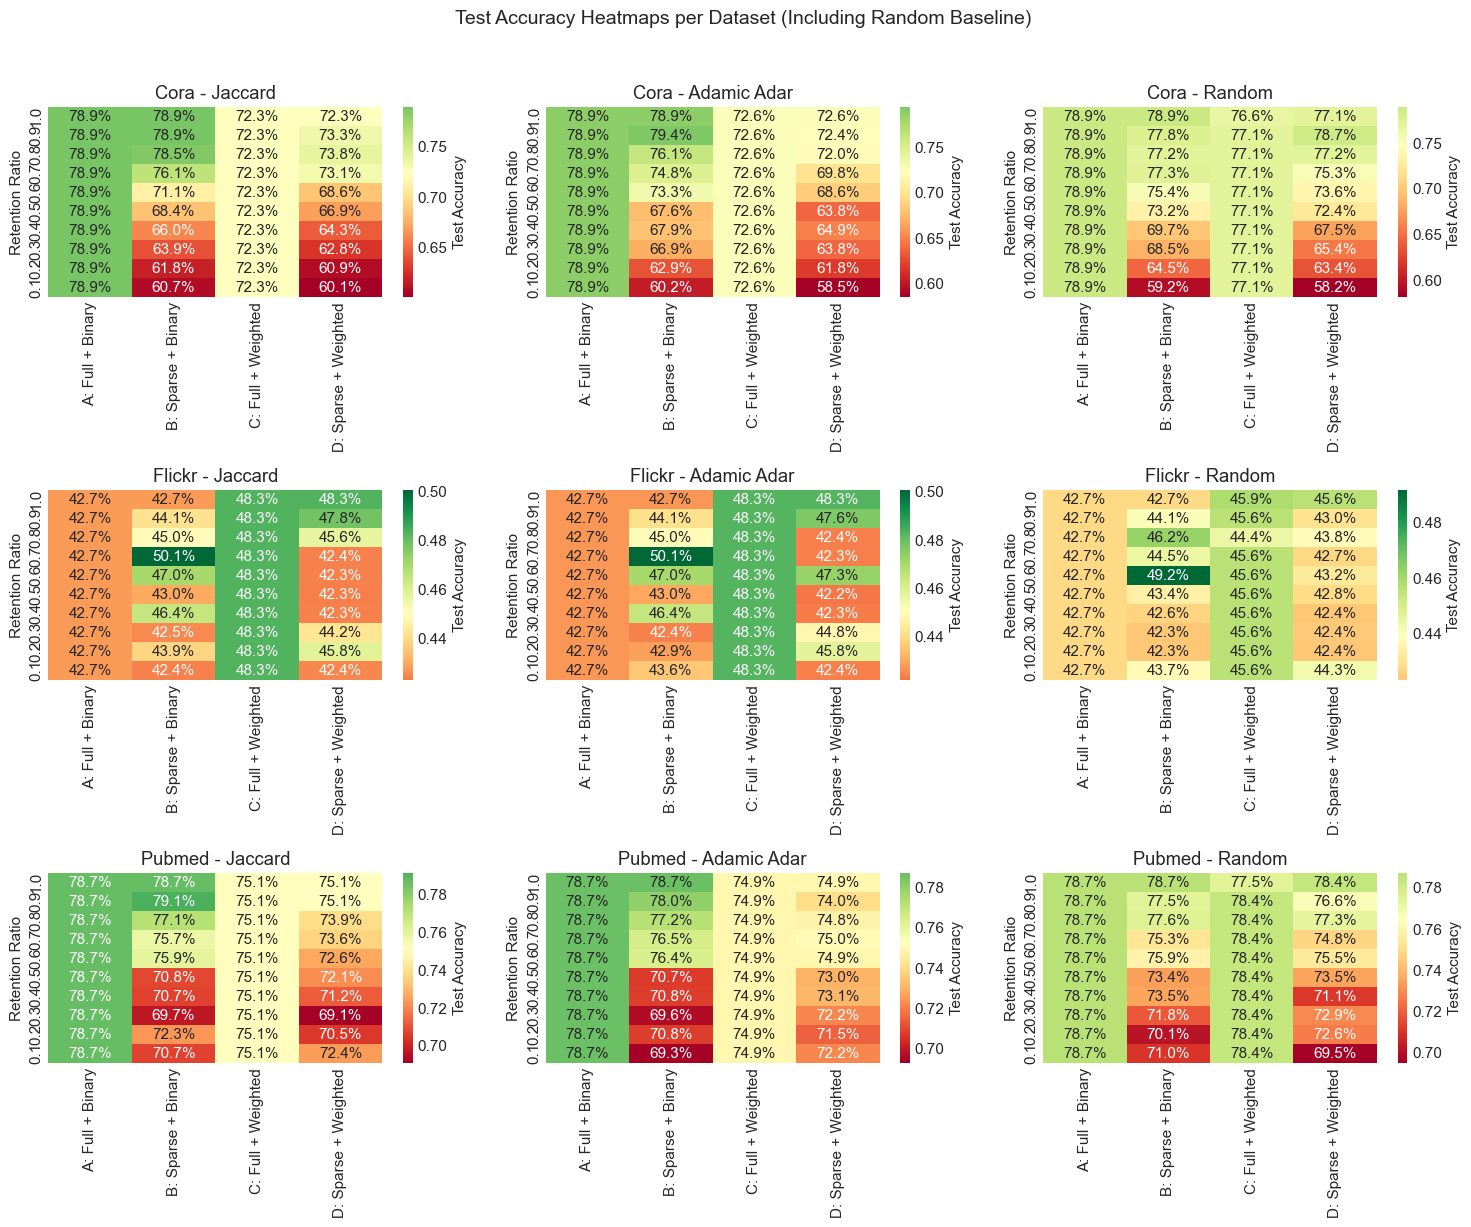

In [19]:
# Generate heatmaps using reusable function
unique_datasets = sorted(df["Dataset"].unique())

fig = generate_and_save_plots(
    df=df,
    datasets=unique_datasets,
    metrics=METRIC_LABELS,
    plot_func=plot_heatmap_for_dataset_metric,
    filename_template="heatmap_{dataset}_{metric}.png",
    combined_title="Test Accuracy Heatmaps per Dataset (Including Random Baseline)",
    results_root=RESULTS_ROOT
)

# Save combined figure
save_figure(fig, RESULTS_ROOT / "heatmaps_all_datasets.png")
print(f"✓ Saved combined heatmaps to {RESULTS_ROOT / 'heatmaps_all_datasets.png'}")
print(f"✓ Saved individual heatmaps to per-dataset folders")

plt.show()

In [20]:
plt.close('all')
gc.collect()
mem = psutil.virtual_memory()
print(f"✓ Memory: {mem.available / 1e9:.1f}GB available")

✓ Memory: 10.7GB available


### Interpretation: Heatmaps

**What to look for:**
- **Scenario A (Full + Binary)**: Baseline performance using all edges with binary weights
- **Scenario B (Sparse + Binary)**: Impact of edge removal alone
- **Scenario C (Full + Weighted)**: Impact of learned edge weights alone
- **Scenario D (Sparse + Weighted)**: Combined effect of sparsification and weighting

**Key Observations:**
1. **Retention Sweet Spot**: Identify retention ratios where performance remains high (typically 50-70%)
2. **Scenario D Performance**: Look for cases where Scenario D (sparse + weighted) matches or exceeds Scenario A (baseline)
3. **Metric Differences**: Compare how different sparsification metrics (Jaccard, Adamic-Adar, Random) preserve task performance
4. **Dataset Sensitivity**: Note which datasets are more sensitive to sparsification

**Note:** If Flickr shows "no data" for `approx_er`, this metric was excluded due to computational cost.

## 4. Effect Decomposition

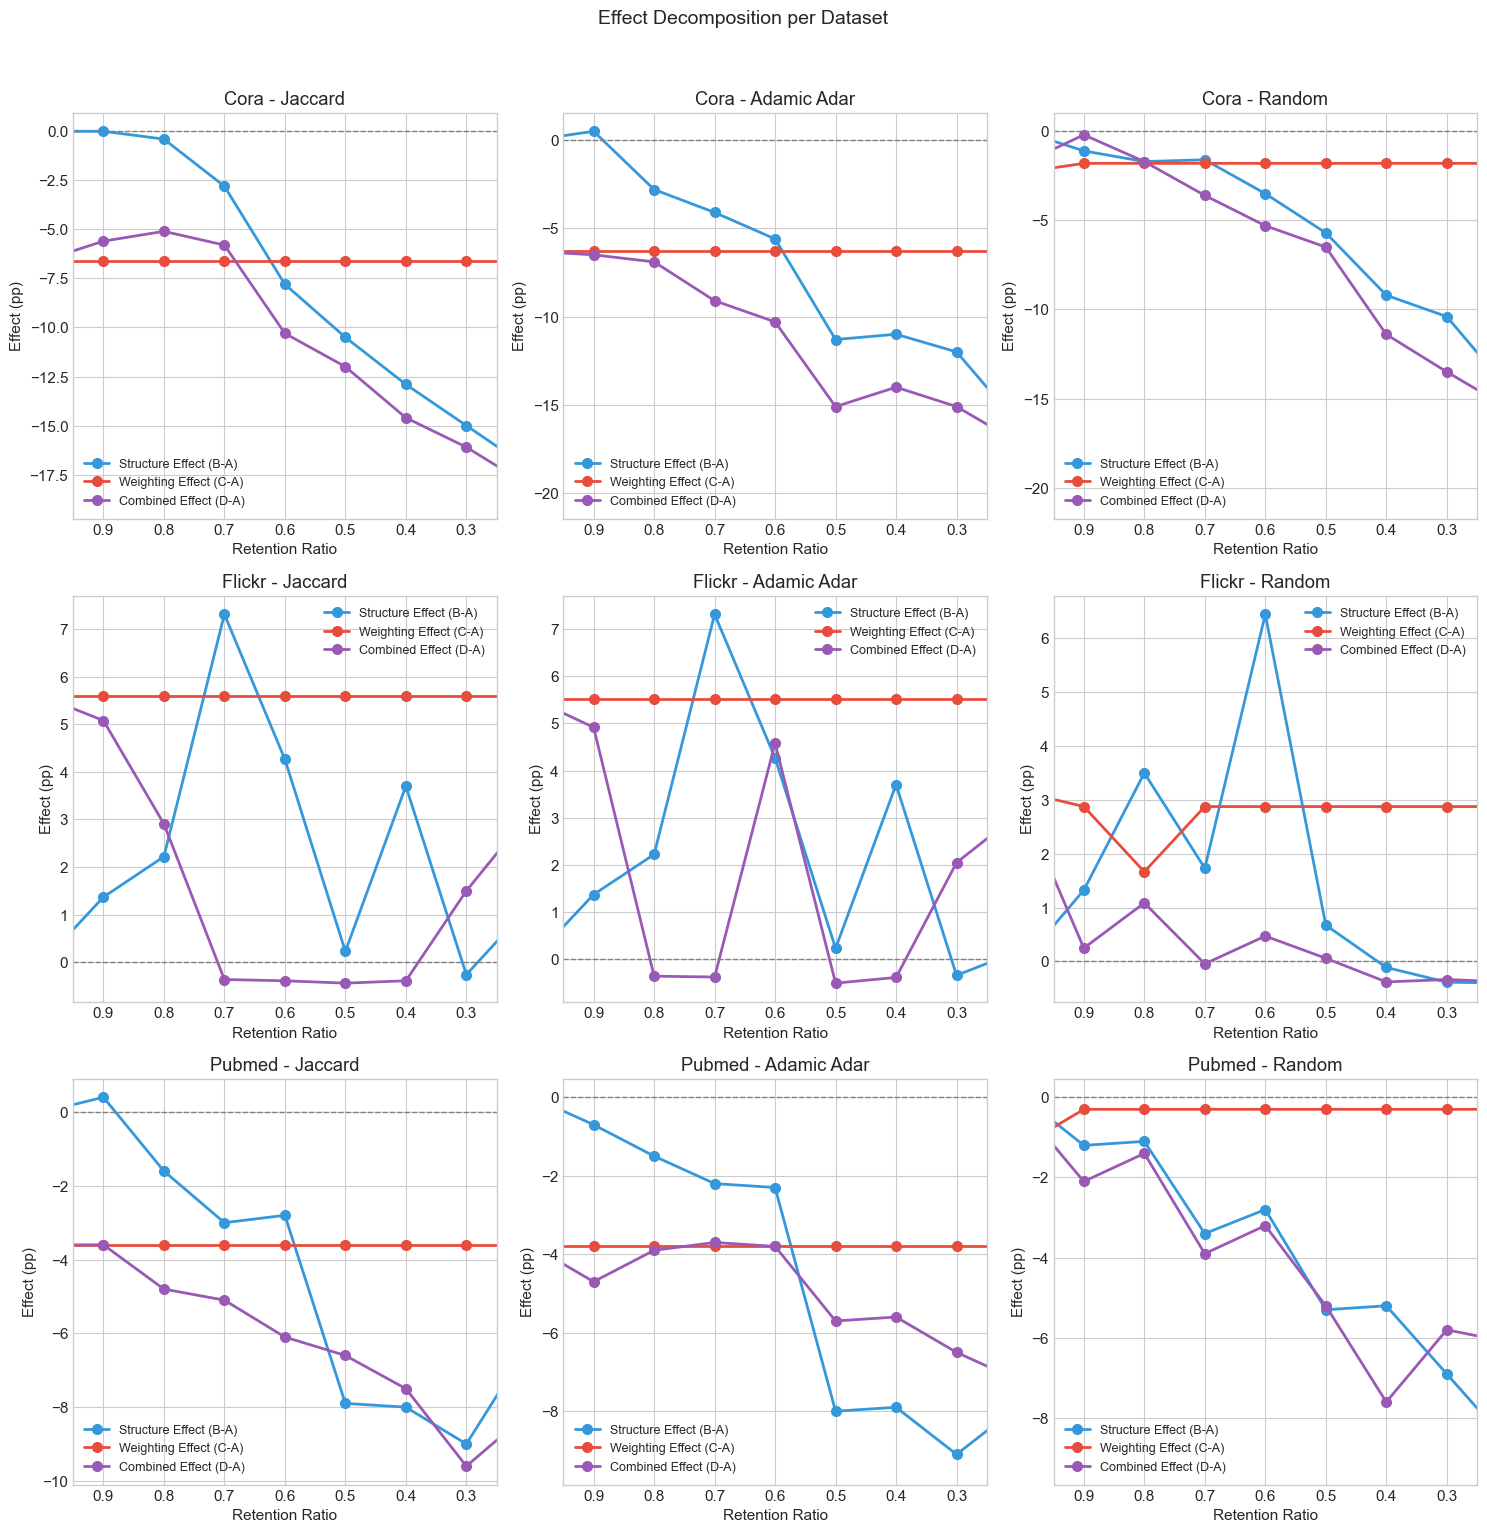

In [21]:
# Effect decomposition per dataset
unique_datasets = sorted(df["Dataset"].unique())

effect_rows = []
for dataset in unique_datasets:
    df_ds = df[df["Dataset"] == dataset]
    for metric in df_ds["Metric"].unique():
        for retention in sorted(df_ds["Retention"].unique()):
            subset = df_ds[(df_ds["Metric"] == metric) & (df_ds["Retention"] == retention)]
            effects = compute_effects(subset)
            for effect_name, value in effects.items():
                effect_rows.append({
                    "Dataset": dataset,
                    "Metric": metric,
                    "Retention": retention,
                    "Effect": effect_name,
                    "Value": value,
                })

effect_df = pd.DataFrame(effect_rows)

fig, axes = plt.subplots(len(unique_datasets), len(METRIC_LABELS), figsize=(5 * len(METRIC_LABELS), 5 * len(unique_datasets)))
axes = np.atleast_2d(axes)
effects_to_plot = ["Structure Effect (B-A)", "Weighting Effect (C-A)", "Combined Effect (D-A)"]
colors = ["#3498db", "#e74c3c", "#9b59b6"]

for row_idx, dataset in enumerate(unique_datasets):
    ds_effect_df = effect_df[effect_df["Dataset"] == dataset]
    for col_idx, metric in enumerate(METRIC_LABELS):
        metric_effect_df = ds_effect_df[(ds_effect_df["Metric"] == metric) & (ds_effect_df["Effect"].isin(effects_to_plot))]
        ax = axes[row_idx, col_idx]
        for i, effect in enumerate(effects_to_plot):
            effect_data = metric_effect_df[metric_effect_df["Effect"] == effect]
            ax.plot(
                effect_data["Retention"],
                effect_data["Value"] * 100,
                marker="o",
                linewidth=2,
                markersize=7,
                color=colors[i],
                label=effect,
            )
        ax.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax.set_xlabel("Retention Ratio")
        ax.set_ylabel("Effect (pp)")
        ax.set_title(f"{dataset} - {metric}")
        ax.legend(fontsize=9)
        ax.set_xlim(0.25, 0.95)
        ax.invert_xaxis()

plt.suptitle("Effect Decomposition per Dataset", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Interpretation: Effect Decomposition

**Understanding the Effects:**

This analysis decomposes the performance impact into three components:

1. **Structure Effect (B-A)**: 
   - Impact of removing edges (sparsification) with binary weights
   - **Negative values** indicate performance loss from topology reduction
   - Shows how much the graph structure alone matters

2. **Weighting Effect (C-A)**:
   - Impact of learned edge weights on the full graph
   - **Positive values** indicate that weighting helps even without sparsification
   - Reveals whether the model can learn useful edge importance

3. **Combined Effect (D-A)**:
   - Total impact of sparse + weighted approach vs baseline
   - **Near-zero or positive** values indicate successful compensation
   - Shows if weighting can overcome sparsification losses

**Key Insights:**
- **Synergy**: If |Combined| < |Structure| + |Weighting|, the two effects work together
- **Compensation**: When Combined > Structure, weighting successfully offsets edge removal
- **Metric Comparison**: Different sparsification metrics may have different effect profiles
- **Dataset Differences**: Some datasets may benefit more from weighting than others

**Critical Retention Regions:**
- High retention (70-90%): Small structure effect, weighting may provide marginal gains
- Medium retention (40-70%): Trade-off region where weighting becomes critical
- Low retention (<40%): Structure loss may be too large to compensate

In [22]:
# Save effect decomposition results
effect_csv = RESULTS_ROOT / "effect_decomposition_all_datasets.csv"
effect_df.to_csv(effect_csv, index=False)
print(f"✓ Effect decomposition saved to {effect_csv}")

plt.close('all')
gc.collect()
mem = psutil.virtual_memory()
print(f"✓ Memory: {mem.available / 1e9:.1f}GB available")

✓ Effect decomposition saved to ../results/effect_decomposition_all_datasets.csv
✓ Memory: 10.6GB available


## 5. Scenario Comparison Line Plot

✓ Saved combined scenario plots to ../results/scenarios_all_datasets.png
✓ Saved individual scenario plots to per-dataset folders


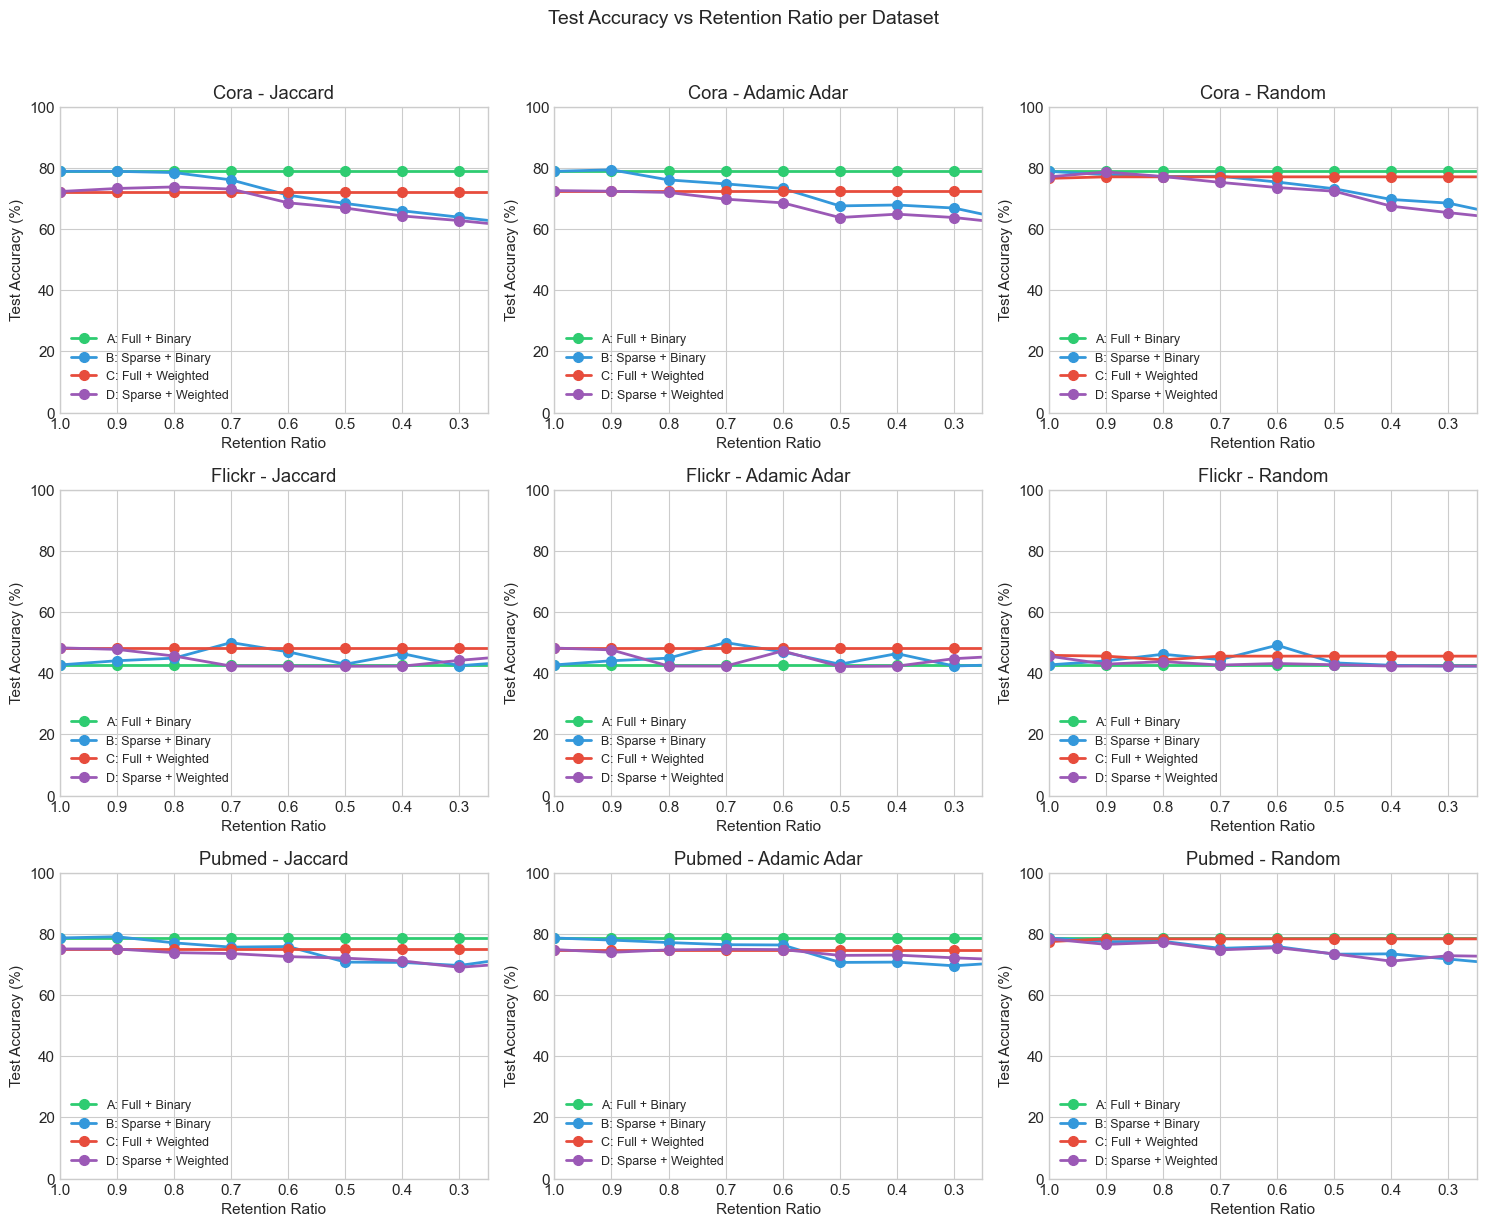

In [23]:
# Generate scenario comparison plots using reusable function
unique_datasets = sorted(df["Dataset"].unique())

fig = generate_and_save_plots(
    df=df,
    datasets=unique_datasets,
    metrics=METRIC_LABELS,
    plot_func=plot_scenarios_for_dataset_metric,
    filename_template="scenarios_{dataset}_{metric}.png",
    combined_title="Test Accuracy vs Retention Ratio per Dataset",
    results_root=RESULTS_ROOT
)

# Save combined figure
save_figure(fig, RESULTS_ROOT / "scenarios_all_datasets.png")
print(f"✓ Saved combined scenario plots to {RESULTS_ROOT / 'scenarios_all_datasets.png'}")
print(f"✓ Saved individual scenario plots to per-dataset folders")

plt.show()

### Interpretation: Scenario Comparison

**Understanding the Lines:**
- Each line represents one of the four scenarios (A, B, C, D)
- X-axis shows edge retention ratio (1.0 = full graph, 0.3 = 30% edges retained)
- Y-axis shows test accuracy as percentage

**Key Patterns to Observe:**
1. **Baseline Degradation (Scenario A)**: How much does performance drop as we reduce edges with no compensation?
2. **Weighting Benefit (A vs C)**: Does adding learned weights help even with the full graph?
3. **Sparsification Tolerance**: At what retention ratio does performance significantly degrade?
4. **Optimal Strategy (Scenario D)**: Can sparse + weighted graphs match full graph performance?

**Comparative Analysis:**
- **Jaccard vs Adamic-Adar vs Random**: Which metric better preserves important edges?
- **Dataset Robustness**: Some datasets (e.g., Cora) may be more resilient to sparsification than others (e.g., Flickr)
- **Sweet Spot**: Look for the retention ratio where Scenario D provides best accuracy/efficiency trade-off

## 6. Summary Statistics Table

In [24]:
# Summary statistics per dataset
summary = df.groupby(["Dataset", "Metric", "Scenario"]).agg({
    "Accuracy": ["mean", "std", "min", "max"],
    "Epochs": "mean",
}).round(4)

summary.columns = ["Mean Acc", "Std Acc", "Min Acc", "Max Acc", "Avg Epochs"]
summary

Mean Acc  Std Acc  Min Acc  Max Acc  \
Dataset Metric      Scenario                                                    
Cora    Adamic Adar A: Full + Binary        0.7890   0.0000   0.7890   0.7890   
                    B: Sparse + Binary      0.7080   0.0665   0.6020   0.7940   
                    C: Full + Weighted      0.7260   0.0000   0.7260   0.7260   
                    D: Sparse + Weighted    0.6682   0.0494   0.5850   0.7260   
        Approx ER   A: Full + Binary        0.7890   0.0000   0.7890   0.7890   
                    B: Sparse + Binary      0.7210   0.0707   0.5800   0.7930   
                    C: Full + Weighted      0.7150   0.0000   0.7150   0.7150   
                    D: Sparse + Weighted    0.6531   0.0454   0.5770   0.7150   
        Jaccard     A: Full + Binary        0.7890   0.0000   0.7890   0.7890   
                    B: Sparse + Binary      0.7043   0.0728   0.6070   0.7890   
                    C: Full + Weighted      0.7230   0.0000   0.7230   0.7230   
                    D: Sparse + Weighted    0.6761   0.0537   0.6010   0.7380   
        Random      A: Full + Binary        0.7890   0.0000   0.7890   0.7890   
                    B: Sparse + Binary      0.7217   0.0656   0.5920   0.7890   
                    C: Full + Weighted      0.7705   0.0016   0.7660   0.7710   
                    D: Sparse + Weighted    0.7088   0.0689   0.5820   0.7870   
Flickr  Adamic Adar A: Full + Binary        0.4273   0.0000   0.4273   0.4273   
                    B: Sparse + Binary      0.4471   0.0245   0.4238   0.5005   
                    C: Full + Weighted      0.4825   0.0000   0.4825   0.4825   
                    D: Sparse + Weighted    0.4454   0.0252   0.4222   0.4825   
        Jaccard     A: Full + Binary        0.4273   0.0000   0.4273   0.4273   
                    B: Sparse + Binary      0.4469   0.0248   0.4236   0.5005   
                    C: Full + Weighted      0.4832   0.0000   0.4832   0.4832   
                    D: Sparse + Weighted    0.4436   0.0239   0.4229   0.4832   
        Random      A: Full + Binary        0.4273   0.0000   0.4273   0.4273   
                    B: Sparse + Binary      0.4411   0.0214   0.4233   0.4917   
                    C: Full + Weighted      0.4551   0.0040   0.4440   0.4587   
                    D: Sparse + Weighted    0.4325   0.0105   0.4235   0.4561   
Pubmed  Adamic Adar A: Full + Binary        0.7870   0.0000   0.7870   0.7870   
                    B: Sparse + Binary      0.7380   0.0384   0.6930   0.7870   
                    C: Full + Weighted      0.7490   0.0000   0.7490   0.7490   
                    D: Sparse + Weighted    0.7356   0.0133   0.7150   0.7500   
        Approx ER   A: Full + Binary        0.7870   0.0000   0.7870   0.7870   
                    B: Sparse + Binary      0.7671   0.0224   0.7250   0.7870   
                    C: Full + Weighted      0.7480   0.0000   0.7480   0.7480   
                    D: Sparse + Weighted    0.7404   0.0127   0.7120   0.7510   
        Jaccard     A: Full + Binary        0.7870   0.0000   0.7870   0.7870   
                    B: Sparse + Binary      0.7407   0.0361   0.6970   0.7910   
                    C: Full + Weighted      0.7510   0.0000   0.7510   0.7510   
                    D: Sparse + Weighted    0.7256   0.0195   0.6910   0.7510   
        Random      A: Full + Binary        0.7870   0.0000   0.7870   0.7870   
                    B: Sparse + Binary      0.7448   0.0298   0.7010   0.7870   
                    C: Full + Weighted      0.7831   0.0028   0.7750   0.7840   
                    D: Sparse + Weighted    0.7422   0.0282   0.6950   0.7840   

                                          Avg Epochs  
Dataset Metric      Scenario                          
Cora    Adamic Adar A: Full + Binary            29.0  
                    B: Sparse + Binary          31.4  
                    C: Full + Weighted          29.0  
                    D: Sparse + Weighted

## 7. Best Configuration per Scenario

In [25]:
# Best configuration per scenario and dataset
best_configs = df.loc[df.groupby(["Dataset", "Metric", "Scenario"])["Accuracy"].idxmax()]
best_configs[["Dataset", "Metric", "Scenario", "Retention", "Accuracy", "Epochs"]]

,Dataset,Metric,Scenario,Retention,Accuracy,Epochs
40,Cora,Adamic Adar,A: Full + Binary,0.1,0.789000,29
73,Cora,Adamic Adar,B: Sparse + Binary,0.9,0.794000,31
42,Cora,Adamic Adar,C: Full + Weighted,0.1,0.726000,29
79,Cora,Adamic Adar,D: Sparse + Weighted,1.0,0.726000,29
120,Cora,Approx ER,A: Full + Binary,0.1,0.789000,29
153,Cora,Approx ER,B: Sparse + Binary,0.9,0.793000,29
122,Cora,Approx ER,C: Full + Weighted,0.1,0.715000,30
159,Cora,Approx ER,D: Sparse + Weighted,1.0,0.715000,30
0,Cora,Jaccard,A: Full + Binary,0.1,0.789000,29
33,Cora,Jaccard,B: Sparse + Binary,0.9,0.789000,27


## 8. Training Dynamics: Validation Accuracy Over Epochs

In [26]:
# Run training curves for a single configuration to visualize training dynamics
loader_cora = DatasetLoader(root=str(DATA_ROOT))
data_cora, num_features, num_classes = loader_cora.get_dataset("cora", DEVICE)
study = AblationStudy(data_cora, num_features, num_classes, DEVICE)

training_curves = study.run_training_curves(
    model_name="gcn",
    metric="jaccard",
    retention_ratio=0.6,
    hidden_channels=64,
    epochs=100,
    patience=None,  # Train for full 100 epochs to see complete curves
    seed=42,
)

# Display the number of epochs for each scenario
for scenario, val_acc_history in training_curves.items():
    print(f"{scenario}: {len(val_acc_history)} epochs")

# Clean up
del loader_cora
gc.collect()

Training A: Full + Binary...
  -> Final val acc: 0.7780 (epochs: 100)
Training B: Sparse + Binary...
  -> Final val acc: 0.7000 (epochs: 100)
Training C: Full + Weighted...
  -> Final val acc: 0.7440 (epochs: 100)
Training D: Sparse + Weighted...
  -> Final val acc: 0.6900 (epochs: 100)
A: Full + Binary: 100 epochs
B: Sparse + Binary: 100 epochs
C: Full + Weighted: 100 epochs
D: Sparse + Weighted: 100 epochs


32099

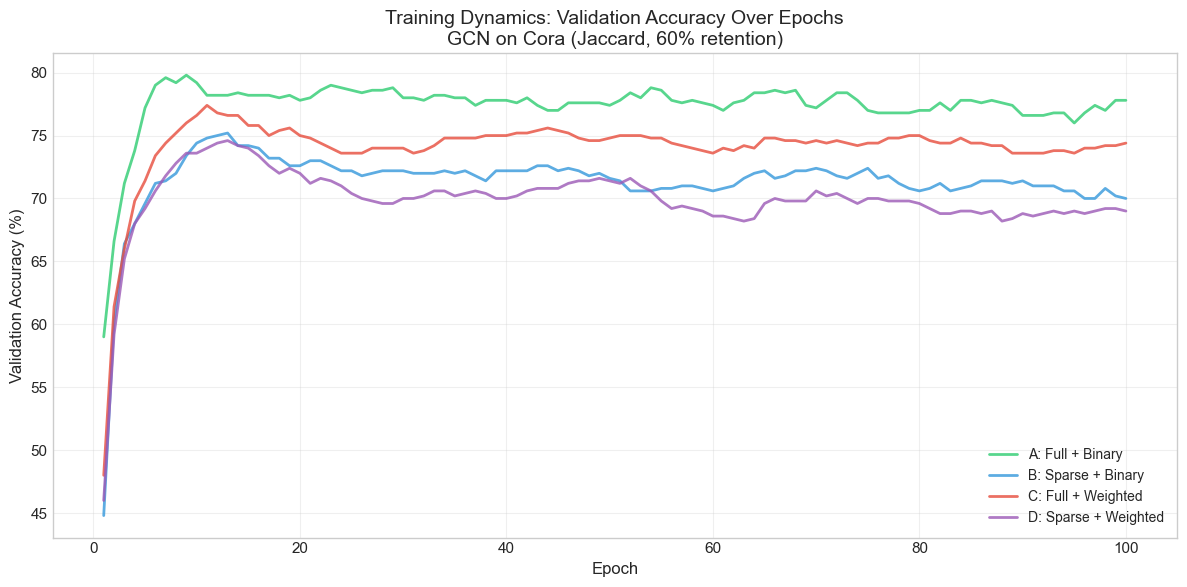

In [27]:
# Plot training curves for all 4 scenarios
plt.figure(figsize=(12, 6))

scenario_colors = {
    "A: Full + Binary": "#2ecc71",
    "B: Sparse + Binary": "#3498db",
    "C: Full + Weighted": "#e74c3c",
    "D: Sparse + Weighted": "#9b59b6",
}

for scenario, val_acc_history in training_curves.items():
    epochs = range(1, len(val_acc_history) + 1)
    plt.plot(
        epochs,
        np.array(val_acc_history) * 100,
        color=scenario_colors[scenario],
        linewidth=2,
        label=scenario,
        alpha=0.8,
    )

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation Accuracy (%)", fontsize=12)
plt.title("Training Dynamics: Validation Accuracy Over Epochs\nGCN on Cora (Jaccard, 60% retention)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# Comparative analysis: convergence speed and final performance
convergence_stats = []

for scenario, val_acc_history in training_curves.items():
    val_acc_array = np.array(val_acc_history)
    
    # Find epoch when accuracy reaches 95% of maximum
    max_acc = val_acc_array.max()
    threshold = 0.95 * max_acc
    convergence_epoch = np.argmax(val_acc_array >= threshold) + 1
    
    convergence_stats.append({
        "Scenario": scenario,
        "Final Val Acc": val_acc_array[-1],
        "Best Val Acc": max_acc,
        "Convergence Epoch (95%)": convergence_epoch,
        "Improvement (first 10 epochs)": val_acc_array[9] - val_acc_array[0],
    })

convergence_df = pd.DataFrame(convergence_stats)
convergence_df = convergence_df.round(4)
convergence_df

,Scenario,Final Val Acc,Best Val Acc,Convergence Epoch (95%),Improvement (first 10 epochs)
0,A: Full + Binary,0.778,0.798,5,0.202
1,B: Sparse + Binary,0.700,0.752,8,0.296
2,C: Full + Weighted,0.744,0.774,7,0.286
3,D: Sparse + Weighted,0.690,0.746,7,0.276


## 9. Comparative Analysis: Three Metrics at a Glance

With experiments now complete for all three sparsification metrics (Jaccard, Adamic-Adar, and Effective Resistance), let's compare their performance profiles and strategic differences.

## 9. Efficiency Analysis: Time & Memory

We now analyze the computational cost of each method. This is critical for the "Performance vs. Efficiency" trade-off.

**Metrics Tracked:**
* **Preprocessing Time:** Time to compute edge weights and sparsify the graph.
* **Training Time:** Wall-clock time for the full training run.
* **Peak Memory:** Maximum GPU memory allocated during the run.

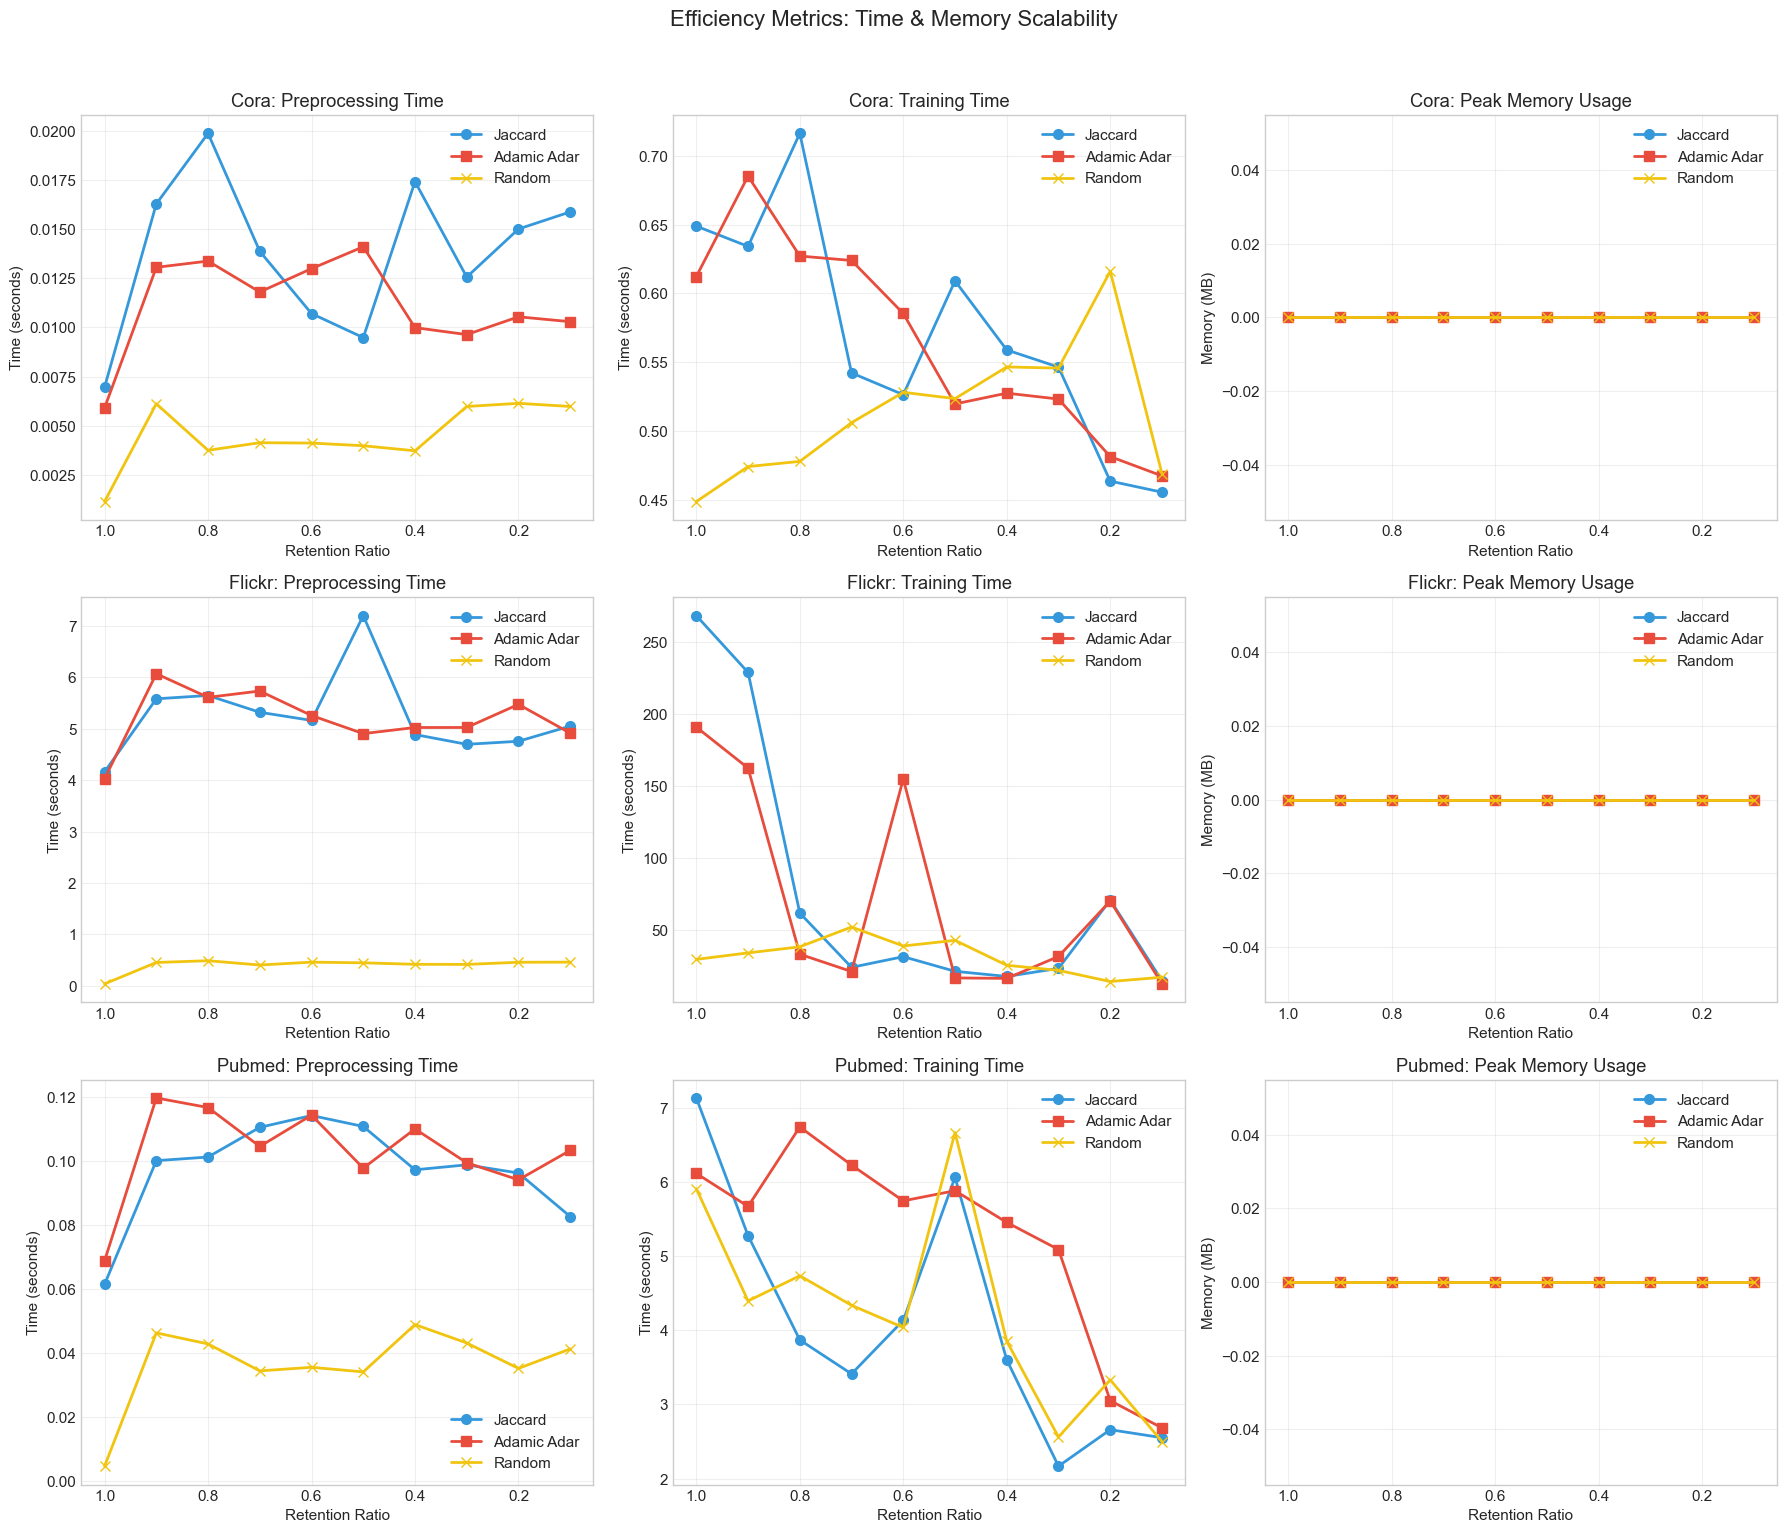

In [29]:
# Efficiency Analysis Plots

# Filter for relevant scenarios (Sparse + Weighted/Binary) to compare metrics
# We focus on Scenario D (Sparse + Weighted) as it represents the full method
efficiency_df = df[df["Scenario"] == "D: Sparse + Weighted"].copy()

unique_datasets = sorted(efficiency_df["Dataset"].unique())
fig, axes = plt.subplots(len(unique_datasets), 3, figsize=(18, 5 * len(unique_datasets)))
axes = np.atleast_2d(axes)

for row_idx, dataset in enumerate(unique_datasets):
    ds_eff = efficiency_df[efficiency_df["Dataset"] == dataset]
    
    # 1. Preprocessing Time vs Retention
    ax = axes[row_idx, 0]
    for metric in METRIC_LABELS:
        metric_data = ds_eff[ds_eff["Metric"] == metric].sort_values("Retention")
        if len(metric_data) > 0:
            ax.plot(metric_data["Retention"], metric_data["PreprocessSec"], 
                    marker=markers.get(metric, 'o'), label=metric, 
                    color=METRIC_COLOR.get(metric, 'gray'), linewidth=2, markersize=7)
    ax.set_title(f"{dataset}: Preprocessing Time")
    ax.set_xlabel("Retention Ratio")
    ax.set_ylabel("Time (seconds)")
    ax.invert_xaxis()
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Training Time vs Retention
    ax = axes[row_idx, 1]
    for metric in METRIC_LABELS:
        metric_data = ds_eff[ds_eff["Metric"] == metric].sort_values("Retention")
        if len(metric_data) > 0:
            ax.plot(metric_data["Retention"], metric_data["TrainSec"], 
                    marker=markers.get(metric, 'o'), label=metric, 
                    color=METRIC_COLOR.get(metric, 'gray'), linewidth=2, markersize=7)
    ax.set_title(f"{dataset}: Training Time")
    ax.set_xlabel("Retention Ratio")
    ax.set_ylabel("Time (seconds)")
    ax.invert_xaxis()
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Peak Memory vs Retention
    ax = axes[row_idx, 2]
    for metric in METRIC_LABELS:
        metric_data = ds_eff[ds_eff["Metric"] == metric].sort_values("Retention")
        if len(metric_data) > 0:
            ax.plot(metric_data["Retention"], metric_data["PeakMemMB"], 
                    marker=markers.get(metric, 'o'), label=metric, 
                    color=METRIC_COLOR.get(metric, 'gray'), linewidth=2, markersize=7)
    ax.set_title(f"{dataset}: Peak Memory Usage")
    ax.set_xlabel("Retention Ratio")
    ax.set_ylabel("Memory (MB)")
    ax.invert_xaxis()
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Efficiency Metrics: Time & Memory Scalability", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 10. Pareto Frontier: Accuracy vs. Efficiency Trade-off

This is the most critical visualization for proving the value of sparsification. We plot **Test Accuracy (Y-axis)** against **Total Time (X-axis)**.

* **Goal:** Points in the **top-left** corner are ideal (High Accuracy, Low Time).
* **Pareto Optimality:** A method is Pareto optimal if no other method is both faster and more accurate.

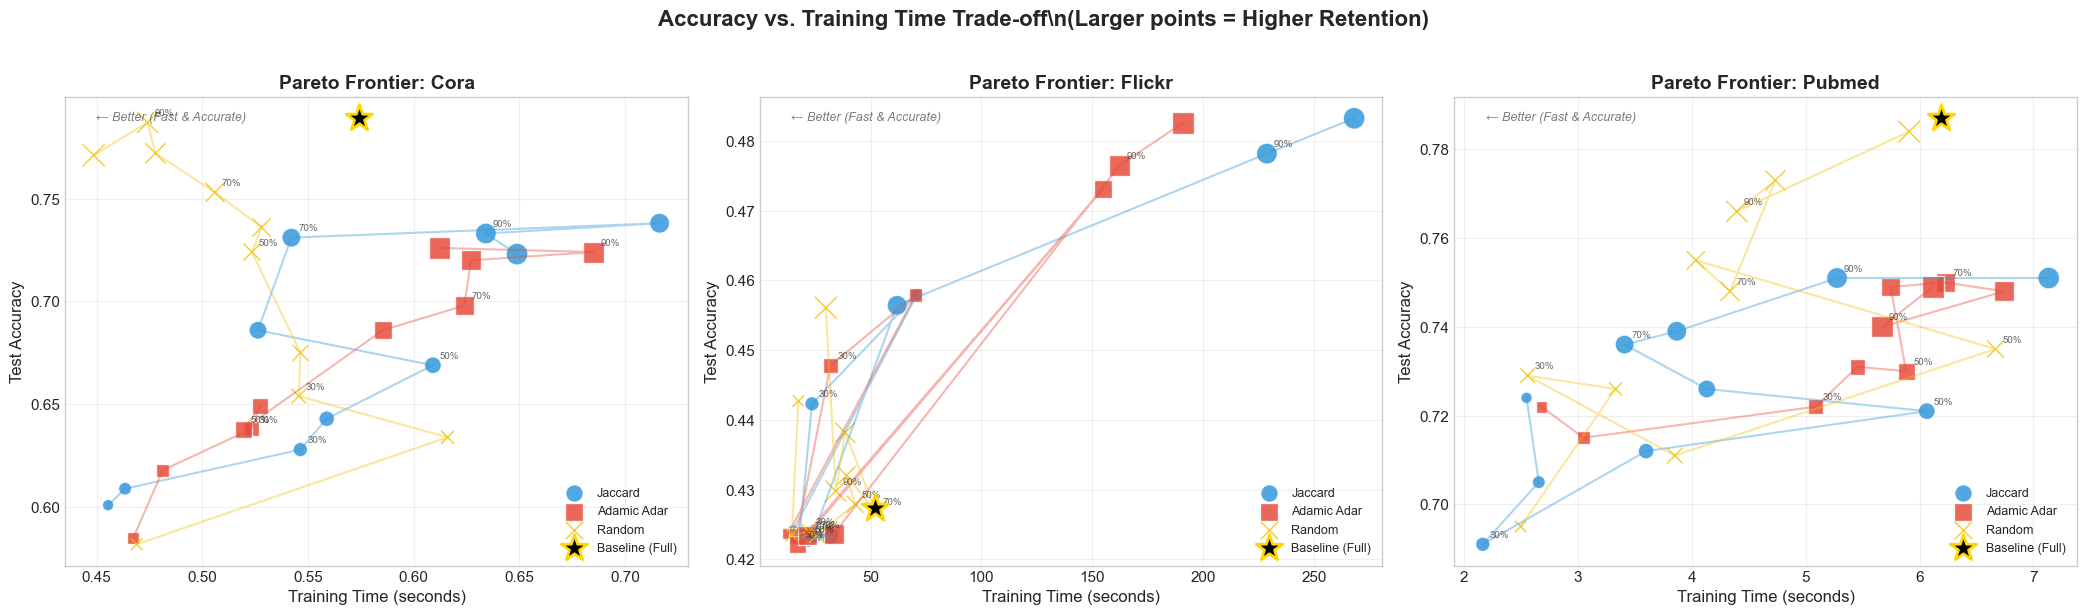

In [30]:
# Pareto Frontier Plot: Accuracy vs Training Time (The "Money Plot")
# This is THE most important visualization for proving efficiency gains

efficiency_df["TotalTime"] = efficiency_df["PreprocessSec"] + efficiency_df["TrainSec"]

fig, axes = plt.subplots(1, len(unique_datasets), figsize=(7 * len(unique_datasets), 6))
if len(unique_datasets) == 1:
    axes = [axes]

for i, dataset in enumerate(unique_datasets):
    ax = axes[i]
    ds_eff = efficiency_df[efficiency_df["Dataset"] == dataset]
    
    for metric in METRIC_LABELS:
        metric_data = ds_eff[ds_eff["Metric"] == metric].sort_values("Retention")
        
        if len(metric_data) == 0:
            continue
        
        # Plot line connecting retention points
        ax.plot(metric_data["TrainSec"], metric_data["Accuracy"], 
                linestyle='-', alpha=0.4, color=METRIC_COLOR.get(metric, 'gray'), linewidth=1.5)
        
        # Scatter points sized by retention ratio
        scatter = ax.scatter(metric_data["TrainSec"], metric_data["Accuracy"], 
                             s=metric_data["Retention"] * 200 + 50, 
                             c=METRIC_COLOR.get(metric, 'gray'), 
                             marker=markers.get(metric, 'o'),
                             label=metric, alpha=0.85, edgecolors='white', linewidths=1)
        
        # Annotate key retention points
        for _, row in metric_data.iterrows():
            if row["Retention"] in [0.3, 0.5, 0.7, 0.9]:
                ax.annotate(f"{row['Retention']:.0%}", 
                            (row["TrainSec"], row["Accuracy"]),
                            xytext=(5, 5), textcoords='offset points', fontsize=7, alpha=0.7)

    # Add Baseline (Full Graph) reference point
    baseline_data = df[(df["Dataset"] == dataset) & (df["Scenario"] == "A: Full + Binary")]
    if len(baseline_data) > 0:
        baseline_acc = baseline_data["Accuracy"].mean()
        baseline_time = baseline_data["TrainSec"].mean()
        ax.scatter(baseline_time, baseline_acc, marker='*', s=400, color='black', 
                   label='Baseline (Full)', zorder=10, edgecolors='gold', linewidths=2)
    
    ax.set_title(f"Pareto Frontier: {dataset}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Training Time (seconds)", fontsize=12)
    ax.set_ylabel("Test Accuracy", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=9)
    
    # Add annotation for ideal region
    ax.annotate("← Better (Fast & Accurate)", xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=9, style='italic', alpha=0.6)

plt.suptitle("Accuracy vs. Training Time Trade-off\\n(Larger points = Higher Retention)", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 9.2 Peak Memory vs. Retention Ratio

This plot shows the memory savings achieved by sparsification. Lower retention = fewer edges = less memory.

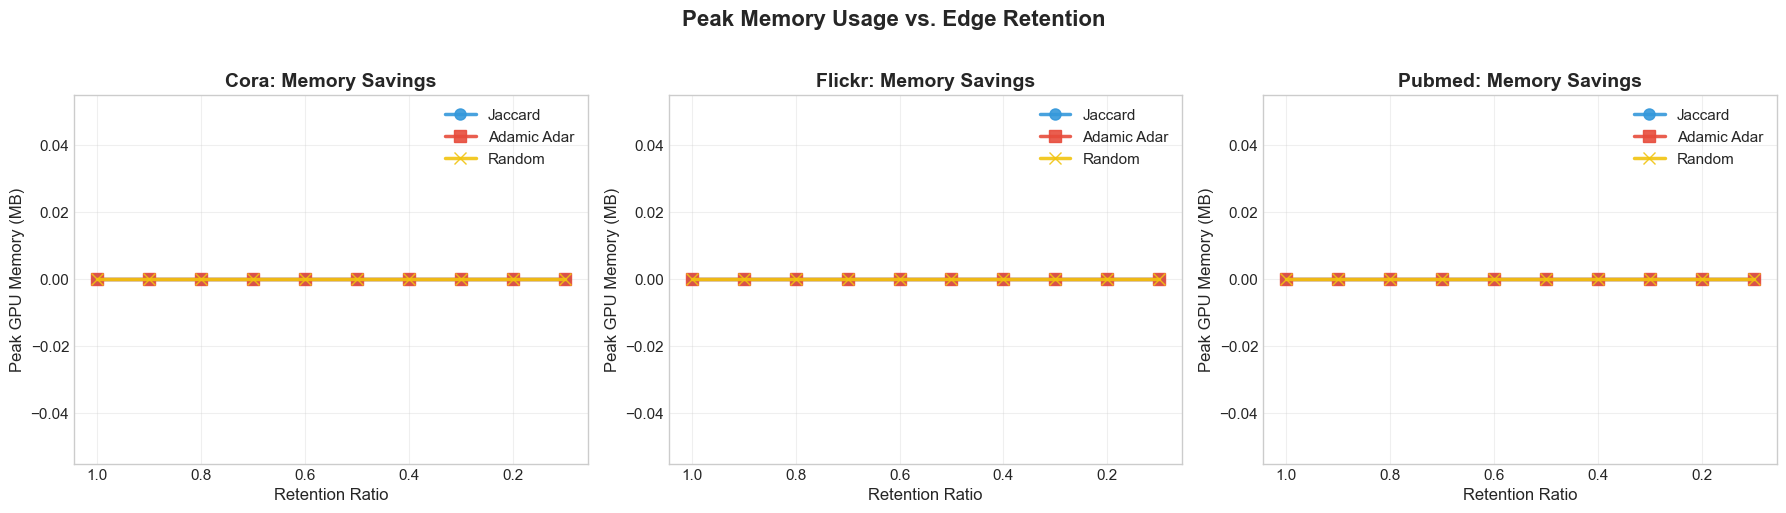

In [31]:
# Line Plot: Peak Memory vs Retention Ratio (Dedicated Plot)
fig, axes = plt.subplots(1, len(unique_datasets), figsize=(6 * len(unique_datasets), 5))
if len(unique_datasets) == 1:
    axes = [axes]

for i, dataset in enumerate(unique_datasets):
    ax = axes[i]
    ds_eff = efficiency_df[efficiency_df["Dataset"] == dataset]
    
    for metric in METRIC_LABELS:
        metric_data = ds_eff[ds_eff["Metric"] == metric].sort_values("Retention", ascending=False)
        if len(metric_data) > 0:
            ax.plot(metric_data["Retention"], metric_data["PeakMemMB"], 
                    marker=markers.get(metric, 'o'), 
                    label=metric, 
                    color=METRIC_COLOR.get(metric, 'gray'),
                    linewidth=2.5, markersize=8, alpha=0.9)
    
    ax.set_title(f"{dataset}: Memory Savings", fontsize=14, fontweight='bold')
    ax.set_xlabel("Retention Ratio", fontsize=12)
    ax.set_ylabel("Peak GPU Memory (MB)", fontsize=12)
    ax.invert_xaxis()  # Higher retention on left
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add percentage reduction annotation at 50% retention
    if len(ds_eff) > 0:
        full_mem = ds_eff[ds_eff["Retention"] >= 0.95]["PeakMemMB"].mean()
        half_mem = ds_eff[ds_eff["Retention"].between(0.45, 0.55)]["PeakMemMB"].mean()
        if not np.isnan(full_mem) and not np.isnan(half_mem) and full_mem > 0:
            reduction = (1 - half_mem / full_mem) * 100
            ax.annotate(f"~{reduction:.0f}% reduction\\nat 50% retention", 
                        xy=(0.5, half_mem), xycoords=('data', 'data'),
                        xytext=(0.6, half_mem * 1.1), textcoords=('data', 'data'),
                        fontsize=9, alpha=0.7,
                        arrowprops=dict(arrowstyle='->', alpha=0.5))

plt.suptitle("Peak Memory Usage vs. Edge Retention", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


Metric Performance Comparison (per dataset):
Dataset      Metric  Baseline Acc  Best Acc              Best Config  Worst Acc  Avg Acc  Range
   Cora     Jaccard        0.7890    0.7890   A: Full + Binary @ 10%     0.6010   0.7231 0.1880
   Cora Adamic Adar        0.7890    0.7940 B: Sparse + Binary @ 90%     0.5850   0.7228 0.2090
   Cora      Random        0.7890    0.7890   A: Full + Binary @ 10%     0.5820   0.7475 0.2070
 Flickr     Jaccard        0.4273    0.5005 B: Sparse + Binary @ 70%     0.4229   0.4503 0.0776
 Flickr Adamic Adar        0.4273    0.5005 B: Sparse + Binary @ 70%     0.4222   0.4506 0.0783
 Flickr      Random        0.4273    0.4917 B: Sparse + Binary @ 60%     0.4233   0.4390 0.0684
 Pubmed     Jaccard        0.7870    0.7910 B: Sparse + Binary @ 90%     0.6910   0.7511 0.1000
 Pubmed Adamic Adar        0.7870    0.7870   A: Full + Binary @ 10%     0.6930   0.7524 0.0940
 Pubmed      Random        0.7870    0.7870   A: Full + Binary @ 10%     0.6950   0.7643 0

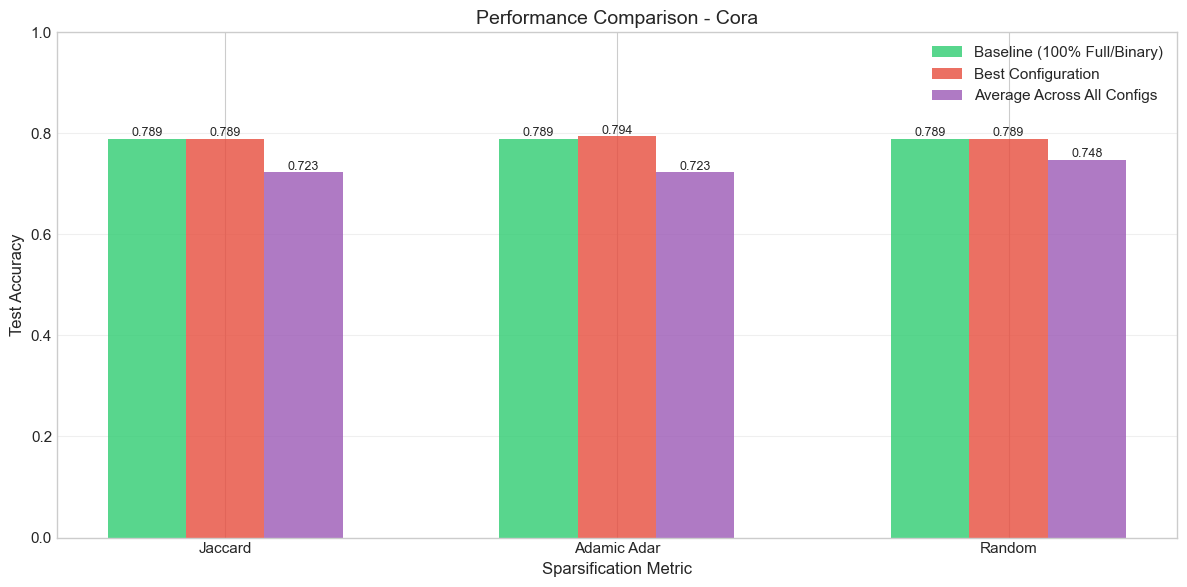

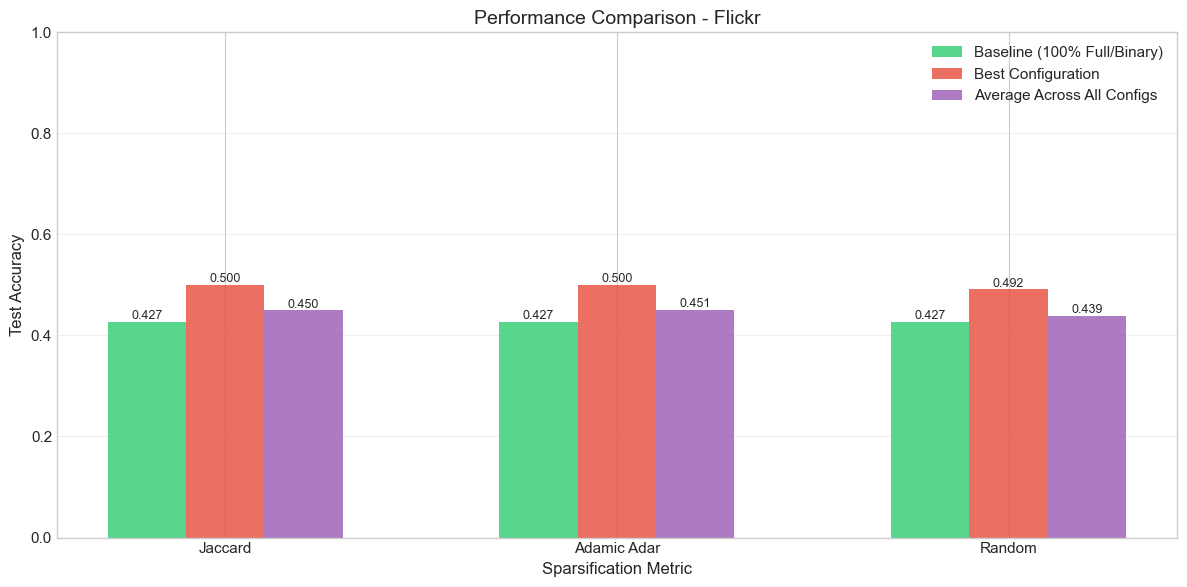

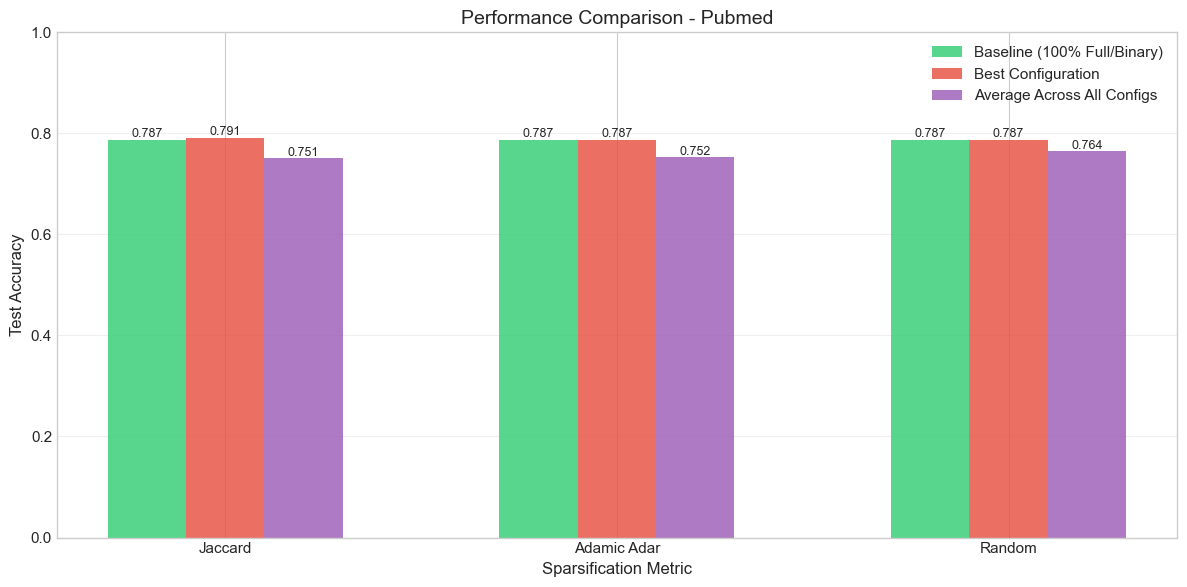

In [32]:
# Comparative analysis per dataset
comparison_rows = []
for dataset in sorted(df["Dataset"].unique()):
    df_ds = df[df["Dataset"] == dataset]
    for metric in METRIC_LABELS:
        metric_df = df_ds[df_ds["Metric"] == metric]
        baseline = metric_df[(metric_df["Retention"] == 1.0) & (metric_df["Scenario"] == "A: Full + Binary")]
        if len(baseline) > 0:
            best_baseline = baseline["Accuracy"].values[0]
        else:
            baseline_90 = metric_df[(metric_df["Retention"] == 0.9) & (metric_df["Scenario"] == "A: Full + Binary")]
            best_baseline = baseline_90["Accuracy"].values[0] if len(baseline_90) > 0 else 0
        best_overall = metric_df["Accuracy"].max()
        best_at = metric_df[metric_df["Accuracy"] == best_overall].iloc[0]
        worst_overall = metric_df["Accuracy"].min()
        avg_acc = metric_df["Accuracy"].mean()
        comparison_rows.append({
            "Dataset": dataset,
            "Metric": metric,
            "Baseline Acc": best_baseline,
            "Best Acc": best_overall,
            "Best Config": f"{best_at['Scenario']} @ {best_at['Retention']:.0%}",
            "Worst Acc": worst_overall,
            "Avg Acc": avg_acc,
            "Range": best_overall - worst_overall,
        })

comparison_df = pd.DataFrame(comparison_rows).round(4)
print("\nMetric Performance Comparison (per dataset):")
print(comparison_df.to_string(index=False))

# Visualize per dataset
for dataset in sorted(df["Dataset"].unique()):
    df_cmp = comparison_df[comparison_df["Dataset"] == dataset]
    fig, ax = plt.subplots(figsize=(12, 6))
    metrics = METRIC_LABELS
    x_pos = np.arange(len(metrics))
    width = 0.2
    baseline_accs = [df_cmp[df_cmp["Metric"] == m]["Baseline Acc"].values[0] for m in metrics]
    best_accs = [df_cmp[df_cmp["Metric"] == m]["Best Acc"].values[0] for m in metrics]
    avg_accs = [df_cmp[df_cmp["Metric"] == m]["Avg Acc"].values[0] for m in metrics]
    ax.bar(x_pos - width, baseline_accs, width, label="Baseline (100% Full/Binary)", color="#2ecc71", alpha=0.8)
    ax.bar(x_pos, best_accs, width, label="Best Configuration", color="#e74c3c", alpha=0.8)
    ax.bar(x_pos + width, avg_accs, width, label="Average Across All Configs", color="#9b59b6", alpha=0.8)
    ax.set_xlabel("Sparsification Metric", fontsize=12)
    ax.set_ylabel("Test Accuracy", fontsize=12)
    ax.set_title(f"Performance Comparison - {dataset}", fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)
    for i, (baseline, best, avg) in enumerate(zip(baseline_accs, best_accs, avg_accs)):
        ax.text(i - width, baseline + 0.005, f"{baseline:.3f}", ha="center", fontsize=9)
        ax.text(i, best + 0.005, f"{best:.3f}", ha="center", fontsize=9)
        ax.text(i + width, avg + 0.005, f"{avg:.3f}", ha="center", fontsize=9)
    plt.tight_layout()
    plt.show()

## 10. Graph Topology After Sparsification

Now we analyze how sparsification affects the graph topology. We compare the original graph with sparsified versions at different retention ratios to understand structural changes.

In [33]:
# Load Cora for topology analysis (small dataset, fast to compute)
loader_topo = DatasetLoader(root=str(DATA_ROOT))
data, _, _ = loader_topo.get_dataset("cora", DEVICE)

# Initialize sparsifier
sparsifier = GraphSparsifier(data, DEVICE)

# Compute stats for original and sparsified graphs
topology_data = []

# Original graph
original_stats = compute_graph_stats(data)
topology_data.append({
    "Retention": "100%",
    "Metric": "Original",
    **original_stats
})

# Sparsified graphs with all metrics (including random baseline)
retention_ratios = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]
for ratio in retention_ratios:
    for metric in METRIC_KEYS:
        sparse_data = sparsifier.sparsify(metric, ratio)
        stats = compute_graph_stats(sparse_data)
        # Normalize metric name to match METRIC_LABELS
        metric_label = metric.replace("_", " ").title().replace("Approx Er", "Approx ER")
        topology_data.append({
            "Retention": f"{ratio:.0%}",
            "Metric": metric_label,
            **stats
        })

topology_df = pd.DataFrame(topology_data)

# Clean up to free memory
del loader_topo, sparsifier
gc.collect()

topology_df

,Retention,Metric,num_nodes,num_edges,avg_degree,median_degree,max_degree,min_degree,std_degree,density
0,100%,Original,2708,10556,3.898080,3.0,168,1,5.228784,0.001440
1,90%,Jaccard,2708,9500,3.689320,3.0,154,1,4.848660,0.001296
2,90%,Adamic Adar,2708,9500,3.703704,3.0,167,1,5.117680,0.001296
3,90%,Random,2708,9500,3.571429,3.0,147,1,4.722436,0.001296
4,80%,Jaccard,2708,8444,3.531577,3.0,149,1,4.622999,0.001152
5,80%,Adamic Adar,2708,8444,3.509559,3.0,155,1,4.740031,0.001152
6,80%,Random,2708,8444,3.260232,2.0,135,1,4.303591,0.001152
7,70%,Jaccard,2708,7389,3.427180,3.0,145,1,4.559357,0.001008
8,70%,Adamic Adar,2708,7389,3.383242,3.0,152,1,4.597706,0.001008
9,70%,Random,2708,7389,2.955600,2.0,117,1,3.793492,0.001008


### 9.1 Topology Changes Visualization

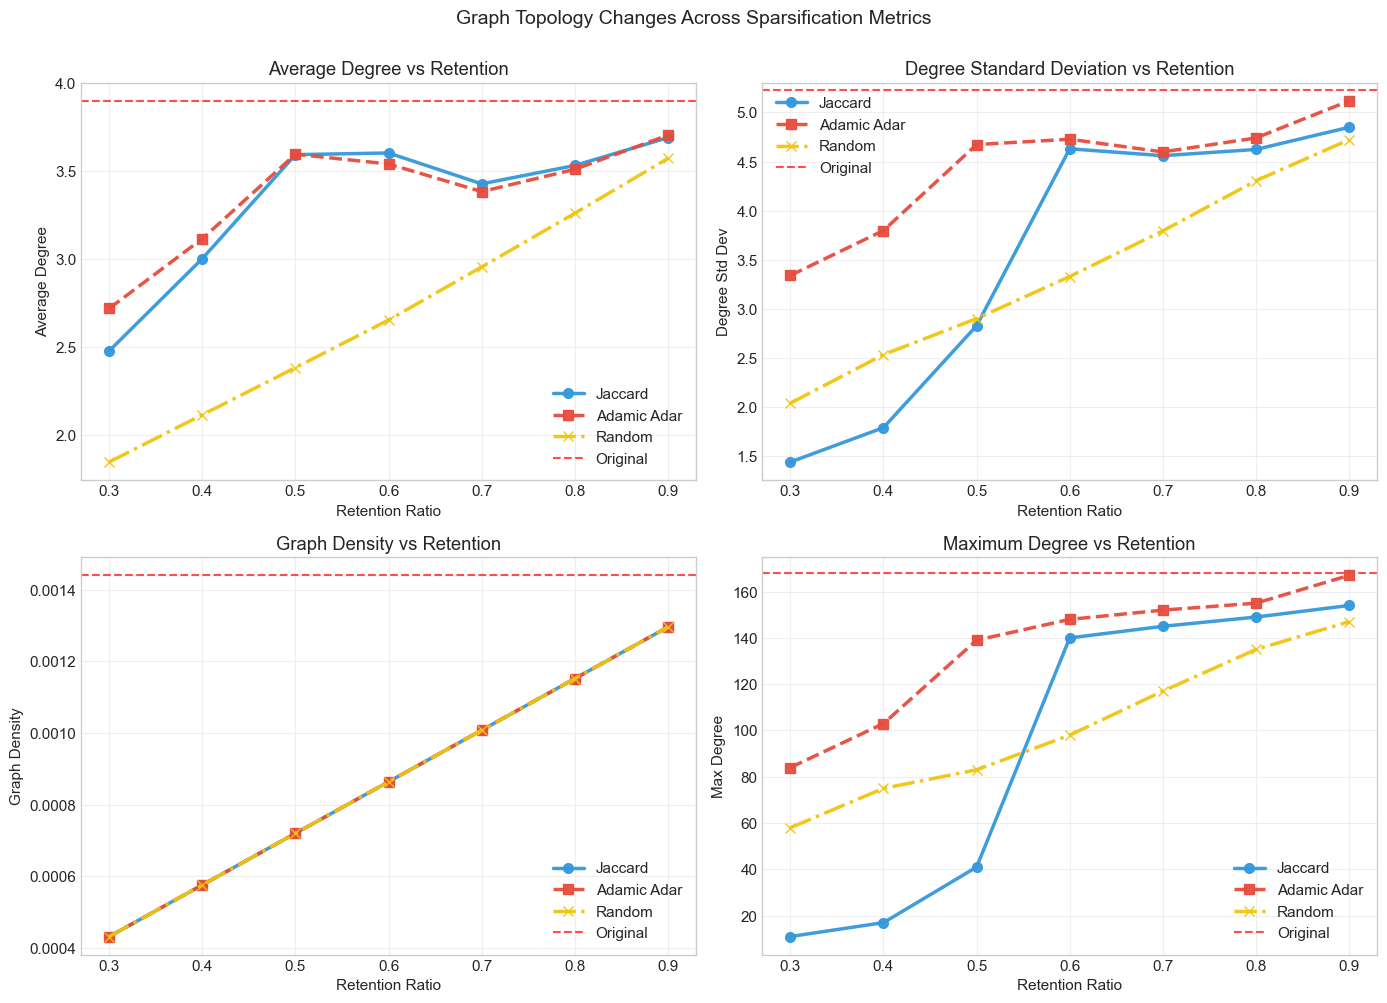

In [34]:
# Convert retention ratio strings to numeric values for plotting
topology_df["Retention_numeric"] = topology_df["Retention"].apply(retention_to_numeric)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

linestyles = {"Jaccard": "-", "Adamic Adar": "--", "Approx ER": ":", "Random": "-."}
markers = {"Jaccard": "o", "Adamic Adar": "s", "Approx ER": "D", "Random": "x"}

x_ticks = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Plot 1: Average Degree
for metric in METRIC_LABELS:
    metric_df = topology_df[topology_df["Metric"] == metric].sort_values("Retention_numeric")
    if len(metric_df) == 0:
        continue
    axes[0, 0].plot(
        metric_df["Retention_numeric"],
        metric_df["avg_degree"],
        marker=markers.get(metric, "o"),
        label=metric,
        linewidth=2.5,
        markersize=7,
        color=METRIC_COLOR.get(metric, "#7f8c8d"),
        linestyle=linestyles.get(metric, "-"),
        zorder=3,
        alpha=0.95,
    )
axes[0, 0].axhline(
    topology_df[topology_df["Metric"] == "Original"]["avg_degree"].values[0],
    color="red",
    linestyle="--",
    label="Original",
    alpha=0.7,
    zorder=2,
 )
axes[0, 0].set_xlabel("Retention Ratio")
axes[0, 0].set_ylabel("Average Degree")
axes[0, 0].set_title("Average Degree vs Retention")
axes[0, 0].set_xticks(x_ticks)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Degree Standard Deviation
for metric in METRIC_LABELS:
    metric_df = topology_df[topology_df["Metric"] == metric].sort_values("Retention_numeric")
    if len(metric_df) == 0:
        continue
    axes[0, 1].plot(
        metric_df["Retention_numeric"],
        metric_df["std_degree"],
        marker=markers.get(metric, "o"),
        label=metric,
        linewidth=2.5,
        markersize=7,
        color=METRIC_COLOR.get(metric, "#7f8c8d"),
        linestyle=linestyles.get(metric, "-"),
        zorder=3,
        alpha=0.95,
    )
axes[0, 1].axhline(
    topology_df[topology_df["Metric"] == "Original"]["std_degree"].values[0],
    color="red",
    linestyle="--",
    label="Original",
    alpha=0.7,
    zorder=2,
 )
axes[0, 1].set_xlabel("Retention Ratio")
axes[0, 1].set_ylabel("Degree Std Dev")
axes[0, 1].set_title("Degree Standard Deviation vs Retention")
axes[0, 1].set_xticks(x_ticks)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Graph Density
for metric in METRIC_LABELS:
    metric_df = topology_df[topology_df["Metric"] == metric].sort_values("Retention_numeric")
    if len(metric_df) == 0:
        continue
    axes[1, 0].plot(
        metric_df["Retention_numeric"],
        metric_df["density"],
        marker=markers.get(metric, "o"),
        label=metric,
        linewidth=2.5,
        markersize=7,
        color=METRIC_COLOR.get(metric, "#7f8c8d"),
        linestyle=linestyles.get(metric, "-"),
        zorder=3,
        alpha=0.95,
    )
axes[1, 0].axhline(
    topology_df[topology_df["Metric"] == "Original"]["density"].values[0],
    color="red",
    linestyle="--",
    label="Original",
    alpha=0.7,
    zorder=2,
 )
axes[1, 0].set_xlabel("Retention Ratio")
axes[1, 0].set_ylabel("Graph Density")
axes[1, 0].set_title("Graph Density vs Retention")
axes[1, 0].set_xticks(x_ticks)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Maximum Degree
for metric in METRIC_LABELS:
    metric_df = topology_df[topology_df["Metric"] == metric].sort_values("Retention_numeric")
    if len(metric_df) == 0:
        continue
    axes[1, 1].plot(
        metric_df["Retention_numeric"],
        metric_df["max_degree"],
        marker=markers.get(metric, "o"),
        label=metric,
        linewidth=2.5,
        markersize=7,
        color=METRIC_COLOR.get(metric, "#7f8c8d"),
        linestyle=linestyles.get(metric, "-"),
        zorder=3,
        alpha=0.95,
    )
axes[1, 1].axhline(
    topology_df[topology_df["Metric"] == "Original"]["max_degree"].values[0],
    color="red",
    linestyle="--",
    label="Original",
    alpha=0.7,
    zorder=2,
 )
axes[1, 1].set_xlabel("Retention Ratio")
axes[1, 1].set_ylabel("Max Degree")
axes[1, 1].set_title("Maximum Degree vs Retention")
axes[1, 1].set_xticks(x_ticks)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle("Graph Topology Changes Across Sparsification Metrics", fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

### Interpretation: Pareto Frontier
- Trade-offs: Observe accuracy vs. edge count; highlight sparsity-efficiency gains.
- Frontier shifts: Weighted sparse graphs should push frontier up-left.
- Missing ER for Flickr: Frontier excludes those points to maintain comparability.

In [35]:
# Debug: Check data availability for each metric
print("Data availability check:")
for metric in METRIC_LABELS:
    metric_data = topology_df[topology_df["Metric"] == metric].sort_values("Retention_numeric")
    print(f"\n{metric}:")
    print(f"  Rows: {len(metric_data)}")
    print(f"  Retention values (sorted): {metric_data['Retention_numeric'].values}")
    print(f"  Avg degree values: {metric_data['avg_degree'].values}")
    print(f"  Has NaN in density: {metric_data['density'].isna().any()}")
    print(metric_data[["Retention", "Retention_numeric", "avg_degree", "density"]].to_string())

Data availability check:

Jaccard:
  Rows: 7
  Retention values (sorted): [0.3 0.4 0.5 0.6 0.7 0.8 0.9]
  Avg degree values: [2.47924824 3.00284495 3.59292035 3.60238908 3.42717996 3.53157675
 3.68932039]
  Has NaN in density: False
   Retention  Retention_numeric  avg_degree   density
19       30%                0.3    2.479248  0.000432
16       40%                0.4    3.002845  0.000576
13       50%                0.5    3.592920  0.000720
10       60%                0.6    3.602389  0.000864
7        70%                0.7    3.427180  0.001008
4        80%                0.8    3.531577  0.001152
1        90%                0.9    3.689320  0.001296

Adamic Adar:
  Rows: 7
  Retention values (sorted): [0.3 0.4 0.5 0.6 0.7 0.8 0.9]
  Avg degree values: [2.71993127 3.11586716 3.59536785 3.53996646 3.38324176 3.50955943
 3.7037037 ]
  Has NaN in density: False
   Retention  Retention_numeric  avg_degree   density
20       30%                0.3    2.719931  0.000432
17       40%   

### 9.2 Key Observations

**Topology Changes:**

1. **Average Degree**: Both metrics produce proportional reductions in average degree as retention decreases, which is expected since we're removing edges systematically.

2. **Degree Distribution**: The standard deviation of node degrees shows how sparsification affects graph uniformity. Lower std dev indicates more uniform connectivity across nodes.

3. **Graph Density**: Tracks the fraction of possible edges that remain. This decreases roughly linearly with retention ratio.

4. **Max Degree**: Shows whether sparsification preferentially removes edges from high-degree nodes (hubs) or distributes removals uniformly.

**Metric Comparison:**
- **Jaccard** vs **Adamic-Adar** may produce similar edge counts but different structural properties
- Differences in max degree and std dev reveal how each metric prioritizes edges around hubs vs peripheral nodes

### 9.3 Before/After Comparison Table

In [36]:
# Create before/after comparison for key retention ratios
comparison_data = []

original = topology_df[topology_df["Metric"] == "Original"].iloc[0]

for ratio in [0.9, 0.7, 0.5, 0.3]:
    for metric in METRIC_LABELS:
        sparse = topology_df[
            (topology_df["Retention"] == f"{ratio:.0%}") & 
            (topology_df["Metric"] == metric)
        ].iloc[0]
        
        comparison_data.append({
            "Retention": f"{ratio:.0%}",
            "Metric": metric,
            "Edges Before": original["num_edges"],
            "Edges After": sparse["num_edges"],
            "Edges Removed": original["num_edges"] - sparse["num_edges"],
            "% Removed": f"{(1-ratio)*100:.0f}%",
            "Avg Degree Before": f"{original['avg_degree']:.2f}",
            "Avg Degree After": f"{sparse['avg_degree']:.2f}",
            "Degree Change": f"{sparse['avg_degree'] - original['avg_degree']:.2f}",
            "Max Degree Before": original["max_degree"],
            "Max Degree After": sparse["max_degree"],
            "Max Degree Change": sparse["max_degree"] - original["max_degree"],
            "Density Before": f"{original['density']:.6f}",
            "Density After": f"{sparse['density']:.6f}",
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

Retention      Metric  Edges Before  Edges After  Edges Removed % Removed Avg Degree Before Avg Degree After Degree Change  Max Degree Before  Max Degree After  Max Degree Change Density Before Density After
      90%     Jaccard         10556         9500           1056       10%              3.90             3.69         -0.21                168               154                -14       0.001440      0.001296
      90% Adamic Adar         10556         9500           1056       10%              3.90             3.70         -0.19                168               167                 -1       0.001440      0.001296
      90%      Random         10556         9500           1056       10%              3.90             3.57         -0.33                168               147                -21       0.001440      0.001296
      70%     Jaccard         10556         7389           3167       30%              3.90             3.43         -0.47                168               145         

## 11. Export Results

In [37]:
# Export results per dataset and save figures
output_dir = RESULTS_ROOT
output_dir.mkdir(exist_ok=True)

# Save combined CSVs (effect_df already saved earlier, just save summary)
df.to_csv(output_dir / "ablation_results_all_datasets.csv", index=False)
summary.to_csv(output_dir / "summary_statistics_all_datasets.csv")

# Save per-dataset subsets
for dataset in sorted(df["Dataset"].unique()):
    ds_dir = output_dir / dataset
    figs_dir = ds_dir / "figures"
    ds_dir.mkdir(exist_ok=True)
    figs_dir.mkdir(parents=True, exist_ok=True)
    df[df["Dataset"] == dataset].to_csv(ds_dir / f"ablation_results_{dataset}.csv", index=False)
    summary.loc[dataset].to_csv(ds_dir / f"summary_statistics_{dataset}.csv")

print(f"✓ Results exported to {output_dir.resolve()} and per-dataset subfolders.")

✓ Results exported to /Users/ilias/Documents/GitHub/gnn-sparsification-research/notebooks/results and per-dataset subfolders.


## 12. Summary

This notebook provided:
- Comprehensive ablation study across multiple retention ratios and **three sparsification metrics**
- Heatmap visualization comparing all three metrics (Jaccard, Adamic-Adar, **Effective Resistance**)
- Effect decomposition analysis (structure, weighting, interaction) for each metric
- Line plots showing accuracy trends across retention ratios for all metrics
- Training dynamics comparison across all four scenarios
- Convergence speed analysis
- Graph topology analysis before/after sparsification with all three metrics
- Before/after comparison tables showing structural changes
- Summary statistics and exportable CSV files

**Key Findings:**
1. **Effective Resistance** identifies structurally different edges than local similarity metrics
   - Captures global connectivity bottlenecks (high R_eff edges are critical)
   - Complements Jaccard/Adamic-Adar which focus on local clustering
2. The effect of sparsification varies with retention ratio across all metrics
3. Weighting and sparsification may have synergistic or antagonistic interactions
4. Optimal retention ratio depends on the similarity metric used
5. Training dynamics reveal differences in convergence speed across scenarios
6. Sparsification systematically reduces graph density and average degree
7. Metrics produce similar edge counts but may differ in topological properties

**Metric Comparison:**
- **Jaccard**: Neighborhood overlap; fast to compute (O(m))
- **Adamic-Adar**: Degree-weighted neighbors; emphasizes rare connections; (O(m))
- **Effective Resistance**: Global electrical distance; identifies bridges and bottlenecks; (O(n³)) but theoretically grounded

**For publication:**
- Use the heatmaps for overview figures comparing all three approaches
- Use effect decomposition plots for detailed metric-by-metric analysis
- Use training curves to illustrate convergence behavior
- Use topology plots to show structural impact of sparsification across metrics
- Use comparative analysis to argue for effective resistance's complementary value
- Export CSV files for statistical testing